In [1]:
# general imports 
import os
from pathlib import Path
import hdmf
import numpy as np
import pandas as pd 
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns
%matplotlib inline 

# nwb specific imports 
import pynwb
from nwbwidgets import nwb2widget
from hdmf_zarr import NWBZarrIO 

In [2]:
# set data path
import sys
import platform
from os.path import join as pjoin

platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_dir = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_dir = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_dir = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_dir = "/media/$USERNAME/Brain2025/"
    
print('data directory set to', data_dir)

data directory set to /data/


In [6]:
# Load metadata CSV 
metadata = pd.read_csv('/data/metadata/npultra_metadata.csv', index_col = False) 
metadata.head()

# Select psilocybin sessions 
filtered_metadata = metadata[metadata.session_type == 'psilocybin']

# Get the asset name 
session_name = filtered_metadata['name'].iloc[2]

# Find the filepath 
data_dir = os.path.join(r'/data/np-ultra-psychedelics/', session_name)
nwb_path_zarr = list(Path(data_dir).glob("*.nwb"))[0]

#print('Found filepath:', nwb_path_zarr) 

In [7]:
io = NWBZarrIO(nwb_path_zarr, mode = 'r') 
nwbfile_zarr = io.read()

In [8]:
stimulus = nwbfile_zarr.stimulus
stimulus_table = stimulus['epochs'][:]
units = nwbfile_zarr.units[:]
analysis = nwbfile_zarr.analysis
analysis_table = analysis['analysis_table'][:]

In [13]:
analysis_table.columns

Index(['ks_unit_id', 'probe', 'probe_type', 'Spontaneous_0_spikes',
       'Spontaneous_1_spikes', 'Spontaneous_2_spikes', 'Spontaneous_3_spikes',
       'Spontaneous_4_spikes', 'RFMapping_0_spikes', 'RFMapping_1_spikes',
       'RFMapping_2_spikes', 'RFMapping_3_spikes', 'mean_waveform',
       'Spontaneous_0_waveform', 'Spontaneous_1_waveform',
       'Spontaneous_2_waveform', 'Spontaneous_3_waveform',
       'Spontaneous_4_waveform', 'RFMapping_0_waveform',
       'RFMapping_1_waveform', 'RFMapping_2_waveform', 'RFMapping_3_waveform',
       'amplitude', 'duration', 'peak_trough_ratio', 'pre_peak_trough_ratio',
       'repolarization_slope', 'recovery_slope', 'avg_ISI', 'baseline_FR',
       'evoked_FR', 'footprint', 'layer', 'region', 'optotagged', 'cell_type',
       'spread', 'bAP_extent', 'bAP_attenuation', 'bAP_idx', 'burst_idx',
       'num_bursts', 'burst_dur', 'burst_proportion', 'Spontaneous_0_isi_cv',
       'Spontaneous_1_isi_cv', 'Spontaneous_2_isi_cv', 'Spontaneous_3_is

In [9]:
def _to_1d_float_array(x):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.array([], dtype=float)
    try:
        arr = np.asarray(x, dtype=float)
    except Exception:
        return np.array([], dtype=float)
    if arr.ndim == 0:
        return np.array([], dtype=float)
    arr = np.ravel(arr)
    arr = arr[np.isfinite(arr)]
    if arr.size >= 2 and not np.all(np.diff(arr) >= 0):
        arr = np.sort(arr)
    return arr

def avg_isi(st, t_start, t_stop):
    st = _to_1d_float_array(st)
    st = st[(st >= t_start) & (st <= t_stop)]
    if st.size < 2: return np.nan
    return float(np.mean(np.diff(st)))

def isi_cv(st, t_start, t_stop):
    st = _to_1d_float_array(st)
    st = st[(st >= t_start) & (st <= t_stop)]
    if st.size < 2: return np.nan
    isis = np.diff(st)
    m = np.mean(isis)
    return float(np.std(isis) / m) if m > 0 else np.nan


# ---------- Main entry (extended) ----------
def add_session_features(analysis_table, stimulus_table, spike_col,
                         bin_size_s=10, 
                         drop_last_s=0.0,):
    """
    Adds per-session features to analysis_table for one spike column (e.g. 'Spontaneous_0_spikes').

    New columns (prefix = spike_col without '_spikes'):
      <prefix>_FR, <prefix>_avgISI, <prefix>_isi_cv,
      <prefix>_FF, <prefix>_LV,
      <prefix>_burst_idx, <prefix>_burst_var,
      synchrony_<prefix>
    If waveform_col is provided:
      wv_pt_gap[_us], wv_halfwidth[_us], wv_pca1, wv_pca2 (per unit)
    """
    prefix = spike_col.replace('_spikes', '')

    # lookup window
    t_start = stimulus_table.loc[stimulus_table['stim_name'] == prefix, 'start_time'].item()
    t_stop  = stimulus_table.loc[stimulus_table['stim_name'] == prefix, 'stop_time'].item()
    if drop_last_s and drop_last_s > 0:
        t_stop = t_stop - float(drop_last_s)

    # ensure columns exist
    new_cols = [
        f'{prefix}_avgISI', f'{prefix}_isi_cv',
    ]
    for c in new_cols:
        if c not in analysis_table.columns:
            analysis_table[c] = np.nan

    # row-wise features
    analysis_table[f'{prefix}_avgISI'] = analysis_table[spike_col].apply(
        lambda st: avg_isi(st, t_start, t_stop)
    )
    analysis_table[f'{prefix}_isi_cv'] = analysis_table[spike_col].apply(
        lambda st: isi_cv(st, t_start, t_stop)
    )
    

    return analysis_table


In [16]:
session_list = ['Spontaneous_0_spikes', 'Spontaneous_1_spikes', 'Spontaneous_2_spikes', 'RFMapping_0_spikes', 'RFMapping_1_spikes',
       'RFMapping_2_spikes',
]
for session in session_list:
    analysis_table = add_session_features(
    analysis_table, stimulus_table,
    spike_col=session,
    bin_size_s=10,            # for FF & synchrony (50 ms)
    drop_last_s=10,            # set 10.0 to shave last 10 s if needed
)

In [22]:
def combine_sessions(df, spike_col_1, spike_col_2):
    prefix_1 = spike_col_1.replace('_spikes', '')
    prefix_2 = spike_col_2.replace('_spikes', '')
    new_col = f'{prefix_1}_{prefix_2}_spikes'

    df[new_col] = [
        np.concatenate([a, b]) for a, b in zip(df[spike_col_1], df[spike_col_2])
    ]
    return df

In [23]:
combine_sessions(analysis_table, 'Spontaneous_0_spikes', 'RFMapping_0_spikes')

ks_unit_id probe                      probe_type  \
id                                                       
2978           0     A  Neuropixels Ultra (Switchable)   
2979           1     A  Neuropixels Ultra (Switchable)   
2980           3     A  Neuropixels Ultra (Switchable)   
2981           4     A  Neuropixels Ultra (Switchable)   
2982           5     A  Neuropixels Ultra (Switchable)   
...          ...   ...                             ...   
3922         128     F  Neuropixels Ultra (Switchable)   
3923         129     F  Neuropixels Ultra (Switchable)   
3924         130     F  Neuropixels Ultra (Switchable)   
3925         131     F  Neuropixels Ultra (Switchable)   
3926         132     F  Neuropixels Ultra (Switchable)   

                                   Spontaneous_0_spikes  \
id                                                        
2978  [48.56640370159239, 48.575770355944314, 48.778...   
2979  [46.73470610980514, 46.7837727119618, 48.61650...   
2980                                                 []   
2981  [56.39906007032399, 58.87485681528599, 71.1226...   
2982  [47.350971966240195, 49.49176915164073, 51.640...   
...                                                 ...   
3922  [123.34974082565196, 178.3252332155623, 218.37...   
3923  [72.21953857737873, 99.02790318076518, 99.4669...   
3924  [46.75567052703916, 46.85780359852882, 47.2702...   
3925  [284.1584952188617, 328.8551806277309, 372.611...   
3926                                                 []   

                                   Spontaneous_1_spikes  \
id                                                        
2978  [2850.4999865439268, 2850.8198194567617, 2851....   
2979  [2850.436553293992, 2850.9020526819795, 2851.1...   
2980  [2853.9664153197946, 2854.3810481079922, 2856....   
2981  [2851.3100521455644, 2851.3955186998646, 2851....   
2982  [2850.7880194985705, 2851.011819204331, 2851.5...   
...                                                 ...   
3922  [2852.638143612291, 2855.224403648433, 2860.00...   
3923  [2850.8015483208624, 2851.219680582209, 2851.7...   
3924  [2850.3650494399362, 2850.6713819879096, 2851....   
3925  [2866.7008742256307, 2878.577410443827, 2879.8...   
3926  [2925.97955558324, 2961.4821312301756, 3006.90...   

                                   Spontaneous_2_spikes  Spontaneous_3_spikes  \
id                                                                              
2978  [5523.935704994677, 5523.948804977454, 5523.95...                   NaN   
2979  [5522.706239944441, 5524.347037787213, 5524.62...                   NaN   
2980  [5525.1561700567445, 5527.561300227949, 5533.3...                   NaN   
2981  [5522.777739850438, 5522.8153064677135, 5522.8...                   NaN   
2982  [5523.045906164534, 5523.059472813365, 5523.31...                   NaN   
...                                                 ...                   ...   
3922  [5530.6196779369175, 5544.782974959097, 5553.4...                   NaN   
3923  [5524.798059528759, 5528.055951176339, 5532.87...                   NaN   
3924  [5541.473916776028, 5549.010597453863, 5553.44...                   NaN   
3925  [5523.891061854074, 5523.9512950329845, 5528.1...                   NaN   
3926  [6003.027066802437, 6151.271653407032, 6292.77...                   NaN   

      Spontaneous_4_spikes                                 RFMapping_0_spikes  \
id                                                                              
2978                   NaN  [1258.0033802686971, 1258.3060465374353, 1260....   
2979                   NaN  [1257.709813987995, 1257.8174471798181, 1257.9...   
2980                   NaN  [1963.8752522281493, 1964.0180520404042, 1964....   
2981                   NaN  [1259.016012270679, 1259.0275122555595, 1259.7...   
2982                   NaN  [1259.0222789291067, 1259.4278783958473, 1260....   
...                    ...                                                ...   
3922         

In [35]:
combine_sessions(analysis_table, 'Spontaneous_1_spikes', 'RFMapping_1_spikes')

ks_unit_id probe                      probe_type  \
id                                                       
2978           0     A  Neuropixels Ultra (Switchable)   
2979           1     A  Neuropixels Ultra (Switchable)   
2980           3     A  Neuropixels Ultra (Switchable)   
2981           4     A  Neuropixels Ultra (Switchable)   
2982           5     A  Neuropixels Ultra (Switchable)   
...          ...   ...                             ...   
3922         128     F  Neuropixels Ultra (Switchable)   
3923         129     F  Neuropixels Ultra (Switchable)   
3924         130     F  Neuropixels Ultra (Switchable)   
3925         131     F  Neuropixels Ultra (Switchable)   
3926         132     F  Neuropixels Ultra (Switchable)   

                                   Spontaneous_0_spikes  \
id                                                        
2978  [48.56640370159239, 48.575770355944314, 48.778...   
2979  [46.73470610980514, 46.7837727119618, 48.61650...   
2980                                                 []   
2981  [56.39906007032399, 58.87485681528599, 71.1226...   
2982  [47.350971966240195, 49.49176915164073, 51.640...   
...                                                 ...   
3922  [123.34974082565196, 178.3252332155623, 218.37...   
3923  [72.21953857737873, 99.02790318076518, 99.4669...   
3924  [46.75567052703916, 46.85780359852882, 47.2702...   
3925  [284.1584952188617, 328.8551806277309, 372.611...   
3926                                                 []   

                                   Spontaneous_1_spikes  \
id                                                        
2978  [2850.4999865439268, 2850.8198194567617, 2851....   
2979  [2850.436553293992, 2850.9020526819795, 2851.1...   
2980  [2853.9664153197946, 2854.3810481079922, 2856....   
2981  [2851.3100521455644, 2851.3955186998646, 2851....   
2982  [2850.7880194985705, 2851.011819204331, 2851.5...   
...                                                 ...   
3922  [2852.638143612291, 2855.224403648433, 2860.00...   
3923  [2850.8015483208624, 2851.219680582209, 2851.7...   
3924  [2850.3650494399362, 2850.6713819879096, 2851....   
3925  [2866.7008742256307, 2878.577410443827, 2879.8...   
3926  [2925.97955558324, 2961.4821312301756, 3006.90...   

                                   Spontaneous_2_spikes  Spontaneous_3_spikes  \
id                                                                              
2978  [5523.935704994677, 5523.948804977454, 5523.95...                   NaN   
2979  [5522.706239944441, 5524.347037787213, 5524.62...                   NaN   
2980  [5525.1561700567445, 5527.561300227949, 5533.3...                   NaN   
2981  [5522.777739850438, 5522.8153064677135, 5522.8...                   NaN   
2982  [5523.045906164534, 5523.059472813365, 5523.31...                   NaN   
...                                                 ...                   ...   
3922  [5530.6196779369175, 5544.782974959097, 5553.4...                   NaN   
3923  [5524.798059528759, 5528.055951176339, 5532.87...                   NaN   
3924  [5541.473916776028, 5549.010597453863, 5553.44...                   NaN   
3925  [5523.891061854074, 5523.9512950329845, 5528.1...                   NaN   
3926  [6003.027066802437, 6151.271653407032, 6292.77...                   NaN   

      Spontaneous_4_spikes                                 RFMapping_0_spikes  \
id                                                                              
2978                   NaN  [1258.0033802686971, 1258.3060465374353, 1260....   
2979                   NaN  [1257.709813987995, 1257.8174471798181, 1257.9...   
2980                   NaN  [1963.8752522281493, 1964.0180520404042, 1964....   
2981                   NaN  [1259.016012270679, 1259.0275122555595, 1259.7...   
2982                   NaN  [1259.0222789291067, 1259.4278783958473, 1260....   
...                    ...                                                ...   
3922         

In [32]:
def add_session_features_both(analysis_table, stimulus_table, both_spike_col, spike_col_1, spike_col_2,
                         bin_size_s=10, 
                         drop_last_s=0.0,):
    """
    Adds per-session features to analysis_table for one spike column (e.g. 'Spontaneous_0_spikes').

    New columns (prefix = spike_col without '_spikes'):
      <prefix>_FR, <prefix>_avgISI, <prefix>_isi_cv,
      <prefix>_FF, <prefix>_LV,
      <prefix>_burst_idx, <prefix>_burst_var,
      synchrony_<prefix>
    If waveform_col is provided:
      wv_pt_gap[_us], wv_halfwidth[_us], wv_pca1, wv_pca2 (per unit)
    """
    prefix = both_spike_col.replace('_spikes', '')
    prefix_1 = spike_col_1.replace('_spikes', '')
    prefix_2 = spike_col_2.replace('_spikes', '')

    # lookup window
    t_start = stimulus_table.loc[stimulus_table['stim_name'] == prefix_1, 'start_time'].item()
    t_stop  = stimulus_table.loc[stimulus_table['stim_name'] == prefix_2, 'stop_time'].item()
    if drop_last_s and drop_last_s > 0:
        t_stop = t_stop - float(drop_last_s)

    # ensure columns exist
    new_cols = [
        f'{prefix}_avgISI', f'{prefix}_isi_cv',
    ]
    for c in new_cols:
        if c not in analysis_table.columns:
            analysis_table[c] = np.nan

    # row-wise features
    analysis_table[f'{prefix}_avgISI'] = analysis_table[both_spike_col].apply(
        lambda st: avg_isi(st, t_start, t_stop)
    )
    analysis_table[f'{prefix}_isi_cv'] = analysis_table[both_spike_col].apply(
        lambda st: isi_cv(st, t_start, t_stop)
    )
    

    return analysis_table


In [33]:
analysis_table = add_session_features_both(
    analysis_table, stimulus_table,
    both_spike_col='Spontaneous_0_RFMapping_0_spikes',
    spike_col_1='Spontaneous_0_spikes',
    spike_col_2='RFMapping_0_spikes',
    bin_size_s=10,            # for FF & synchrony (50 ms)
)

In [36]:
analysis_table = add_session_features_both(
    analysis_table, stimulus_table,
    both_spike_col='Spontaneous_1_RFMapping_1_spikes',
    spike_col_1='Spontaneous_1_spikes',
    spike_col_2='RFMapping_1_spikes',
    bin_size_s=10,            # for FF & synchrony (50 ms)
)

In [39]:
def calculate_FR(spike_times, bin_size=10, t_start=None, t_end=None):
    """ 
    Calculate spike counts and firing rate from time bins 
    
    Parameters 
    ----------
    spike_times : numpy.ndarray
        Time points when spikes occurred (in ms or sec — match bin_size units)
    bin_size : float
        Width of time bin (same units as spike_times)
    t_start : float, optional
        Start time of binning window. If None, inferred from spike_times.
    t_end : float, optional
        End time of binning window. If None, inferred from spike_times.
    
    Returns 
    -------
    spike_counts : numpy.ndarray
        Number of spikes in each time bin 
    bin_edges : numpy.ndarray
        Array of bin edge times 
    firing_rate : numpy.ndarray
        Firing rate in each bin (spikes/sec if bin_size is in ms)
    """
    spike_times = np.asarray(spike_times)

    # Infer t_start/t_end if not provided
    if t_start is None:
        t_start = np.floor(np.min(spike_times))
    if t_end is None:
        t_end = np.ceil(np.max(spike_times))

    # Create time bins
    time_bins = np.arange(t_start, t_end + bin_size, bin_size)

    # Count spikes
    spike_counts, bin_edges = np.histogram(spike_times, bins=time_bins)

    # Convert to firing rate (Hz)
    firing_rate = spike_counts / (bin_size)  # if bin_size in ms

    return spike_counts, bin_edges, firing_rate


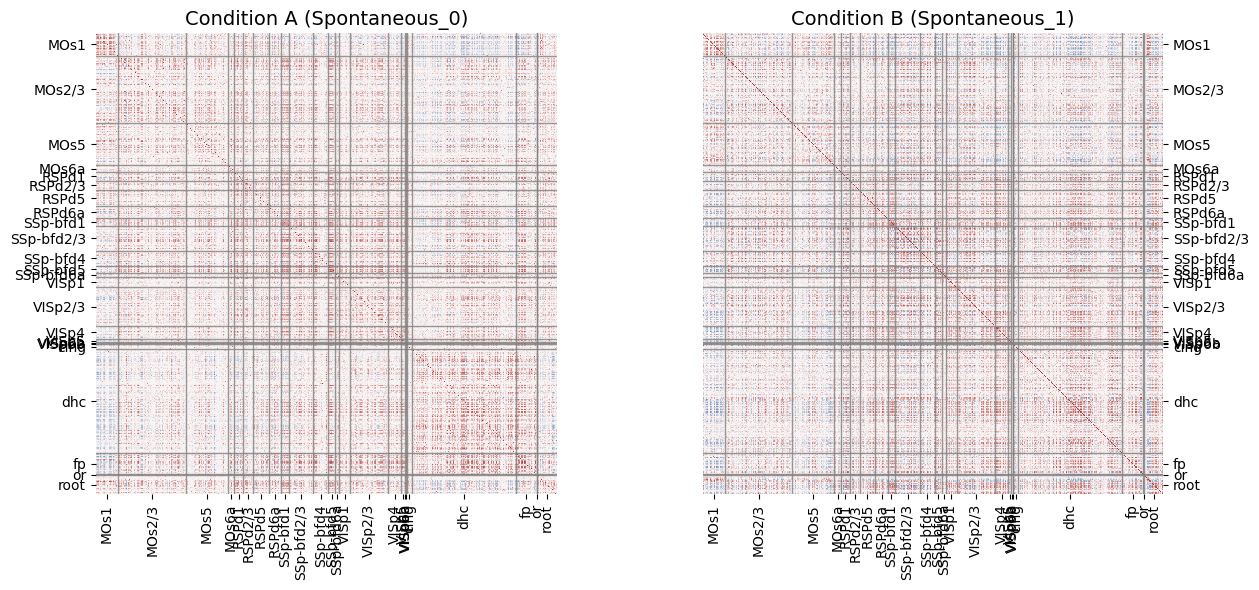

In [40]:
# ---- 0) Build per-condition FR matrices with SAME units ----
# Collect per-unit data and keep only units that are valid in BOTH conditions
valid_idx = []
layers_all = []
fr0 = []  # Spontaneous_0 per-unit FR vectors
fr1 = []  # RFMapping_0 (or whatever) per-unit FR vectors

for unit_idx in range(len(analysis_table)):
    layer = analysis_table.iloc[unit_idx]['layer']

    st0 = analysis_table.iloc[unit_idx].get('Spontaneous_0_spikes', [])
    st1 = analysis_table.iloc[unit_idx].get('Spontaneous_1_spikes', [])

    if layer is None or st0 is None or st1 is None or len(st0) == 0 or len(st1) == 0:
        continue

    st0 = np.asarray(st0)
    st1 = np.asarray(st1)

    # windows for each condition (adjust names if needed)
    t0_start = stimulus_table.loc[stimulus_table['stim_name'] == 'Spontaneous_0', 'start_time'].item()
    t0_stop  = stimulus_table.loc[stimulus_table['stim_name'] == 'Spontaneous_0', 'stop_time'].item()

    t1_start = stimulus_table.loc[stimulus_table['stim_name'] == 'Spontaneous_1', 'start_time'].item()
    t1_stop  = stimulus_table.loc[stimulus_table['stim_name'] == 'Spontaneous_1', 'stop_time'].item()

    # (optional) drop last 10 s:
    t0_stop_adj = t0_stop - 10
    t1_stop_adj = t1_stop - 10

    st0 = st0[(st0 >= t0_start) & (st0 <= t0_stop_adj)]
    st1 = st1[(st1 >= t1_start) & (st1 <= t1_stop_adj)]
    if len(st0) == 0 or len(st1) == 0:
        continue

    # compute FR with same binning lengths
    bin_size = 10  # seconds or ms—match your units
    _, be0, fr_vec0 = calculate_FR(st0, bin_size=bin_size, t_start=t0_start, t_end=t0_stop_adj)
    _, be1, fr_vec1 = calculate_FR(st1, bin_size=bin_size, t_start=t1_start, t_end=t1_stop_adj)

    # require matching number of bins across units for each condition
    # (skip units that end up with different-length vectors—rare if windows consistent)
    if fr0 and (len(fr_vec0) != len(fr0[0]) or len(fr_vec1) != len(fr1[0])):
        continue

    # skip zero-variance (flat) units to avoid NaNs in corr
    if np.std(fr_vec0) == 0 or np.std(fr_vec1) == 0:
        continue

    valid_idx.append(unit_idx)
    layers_all.append(layer)
    fr0.append(fr_vec0)
    fr1.append(fr_vec1)

fr0 = np.array(fr0)  # shape: [n_units, n_bins0]
fr1 = np.array(fr1)  # shape: [n_units, n_bins1]
layers_all = np.array(layers_all)

# ---- 1) Common sorting by LAYER for both matrices ----
sorted_idx = np.argsort(layers_all)
sorted_layers = layers_all[sorted_idx]
fr0_sorted = fr0[sorted_idx]
fr1_sorted = fr1[sorted_idx]

# ---- 2) Correlation matrices with same unit order ----
corr0 = np.corrcoef(fr0_sorted)
corr1 = np.corrcoef(fr1_sorted)

# ---- 3) Shared boundaries/ticks from the same sorted_layers ----
unique_layers, counts = np.unique(sorted_layers, return_counts=True)
layer_boundaries = np.cumsum(counts)                 # e.g., [nL23, nL23+nL4, ...]
tick_positions = layer_boundaries - counts/2.0       # centers

# ---- 4) Plot side by side using the same boundaries/ticks ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# ensure arrays for safety
tick_positions = np.asarray(tick_positions, dtype=float)
unique_layers = list(unique_layers)

for ax, (mat, title) in zip(
    axes,
    [(corr0, "Condition A (Spontaneous_0)"),
     (corr1, "Condition B (Spontaneous_1)")]
):
    # Draw heatmap (do NOT pass yticklabels=True/False here; we will set them explicitly)
    sns.heatmap(mat, cmap='vlag', center=0, square=True,
                xticklabels=False, yticklabels=False, ax=ax, cbar=False)

    ax.set_title(title, fontsize=14)

    # Layer boundaries
    for b in layer_boundaries[:-1]:
        ax.axhline(b, color='gray', linestyle='-', linewidth=1.0, alpha=0.8)
        ax.axvline(b, color='gray', linestyle='-', linewidth=1.0, alpha=0.8)

    # X ticks (centers of groups) for both plots
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(unique_layers, fontsize=10, rotation=90)

# --- Y ticks / labels ---
# Left plot: labels on the LEFT
axes[0].set_yticks(tick_positions)
axes[0].set_yticklabels(unique_layers, fontsize=10)
axes[0].tick_params(axis='y', labelleft=True, labelright=False)

# Right plot: labels on the RIGHT
axes[1].set_yticks(tick_positions)
axes[1].set_yticklabels(unique_layers, fontsize=10)
axes[1].yaxis.tick_right()
axes[1].tick_params(axis='y', labelright=True, labelleft=False)

# (Paranoia) Ensure labels are visible even with shared axes
for ax in axes:
    for lab in ax.get_yticklabels():
        lab.set_visible(True)

plt.tight_layout()
plt.show()


In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

def pca_dbscan_pipeline(
    X,                               # DataFrame of numeric features
    min_samples=None,                # DBSCAN min_samples (auto if None)
    target_cumvar=0.90,              # target cumulative variance for PCA
    show_plots=True,                 # show scree & k-distance plots
    return_all=False                 # return intermediate results too
):
    # ---- Scale ----
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ---- PCA (full) ----
    pca = PCA()
    X_pca_full = pca.fit_transform(X_scaled)
    explained = pca.explained_variance_ratio_
    cum_explained = np.cumsum(explained)
    pcs = np.arange(1, len(explained)+1)

    # ---- Elbow via "max distance to chord" ----
    p1 = np.array([pcs[0], cum_explained[0]])
    p2 = np.array([pcs[-1], cum_explained[-1]])
    line_vec = p2 - p1
    line_vec = line_vec / np.linalg.norm(line_vec)
    pts = np.vstack([pcs, cum_explained]).T
    p1_to_pts = pts - p1
    proj_len = p1_to_pts @ line_vec
    proj_pts = p1 + np.outer(proj_len, line_vec)
    dists = np.linalg.norm(pts - proj_pts, axis=1)
    elbow_idx = int(np.argmax(dists))          # 0-based
    n_pc_elbow = elbow_idx + 1                 # 1-based

    # ---- 90% cumulative rule ----
    n_pc_90 = int(np.searchsorted(cum_explained, target_cumvar) + 1)
    n_pc = max(n_pc_elbow, n_pc_90)

    if show_plots:
        # Scree plot
        plt.figure(figsize=(7,5))
        plt.plot(pcs, explained*100, marker='o', label='Individual PC')
        plt.plot(pcs, cum_explained*100, marker='s', label='Cumulative')
        plt.scatter(n_pc, cum_explained[n_pc-1]*100, s=120, edgecolor='k', zorder=5, label=f'Chosen PCs = {n_pc}')
        plt.xlabel('Principal Component')
        plt.ylabel('Variance Explained (%)')
        plt.title('Scree Plot (auto elbow + 90% rule)')
        plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    # ---- Reduce to chosen PCs ----
    X_embed = X_pca_full[:, :n_pc]

    # ---- DBSCAN params: min_samples ----
    if min_samples is None:
        # rule-of-thumb: ~2× dimensionality (bounded between 5 and 20)
        min_samples = int(np.clip(2*n_pc, 5, 20))

    # ---- k-distance plot to pick eps ----
    nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_embed)
    distances, _ = nbrs.kneighbors(X_embed)
    k_dist = np.sort(distances[:, -1])

    if show_plots:
        plt.figure(figsize=(6,4))
        plt.plot(k_dist)
        plt.ylabel(f'{min_samples}-NN distance')
        plt.xlabel('Points sorted by distance')
        plt.title('k-distance plot (choose eps near the elbow)')
        plt.grid(True); plt.tight_layout(); plt.show()

    # A simple automatic eps guess: median-to-95th quantile midpoint
    eps_guess = float(0.5*(np.percentile(k_dist, 50) + np.percentile(k_dist, 95)))

    # ---- Run DBSCAN ----
    db = DBSCAN(eps=eps_guess, min_samples=min_samples)
    labels = db.fit_predict(X_embed)

    # ---- Diagnostics ----
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_frac = float(np.mean(labels == -1))
    if n_clusters >= 2 and np.sum(labels != -1) > n_clusters:
        sil = float(silhouette_score(X_embed[labels!=-1], labels[labels!=-1]))
    else:
        sil = np.nan

    print(f'Chosen PCs: {n_pc} (elbow={n_pc_elbow}, 90%={n_pc_90})')
    print(f'DBSCAN eps≈{eps_guess:.3f}, min_samples={min_samples}')
    print(f'Clusters found: {n_clusters} | Noise fraction: {noise_frac:.2%} | Silhouette (non-noise): {sil:.3f}')

    # ---- 2D visualization ----
    if show_plots:
        if X_embed.shape[1] >= 2:
            plot_2d = X_embed[:, :2]
        else:
            plot_2d = PCA(n_components=2).fit_transform(X_embed)

        plt.figure(figsize=(6,5))
        for lab in sorted(set(labels)):
            m = labels == lab
            lbl = f'Cluster {lab}' if lab != -1 else 'Noise'
            plt.scatter(plot_2d[m,0], plot_2d[m,1], s=20, alpha=0.7, label=lbl)
        plt.legend()
        plt.xlabel('PC1'); plt.ylabel('PC2')
        plt.title(f'DBSCAN Clusters (eps≈{eps_guess:.3f}, min_samples={min_samples})')
        plt.tight_layout(); plt.show()

    if return_all:
        return {
            'labels': labels,
            'X_embed': X_embed,
            'scaler': scaler,
            'pca': pca,
            'n_pc': n_pc,
            'eps_guess': eps_guess,
            'min_samples': min_samples,
            'k_dist': k_dist
        }
    else:
        return labels

In [89]:
eps_list = np.linspace(0.1, 2.0, 20)   # scale depends on your PCA output
min_samples_list = [5, 8, 10, 15]

grid = []
for ms in min_samples_list:
    for e in eps_list:
        db = DBSCAN(eps=e, min_samples=ms).fit(result['X_embed'])
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise = np.mean(labels == -1)
        grid.append((e, ms, n_clusters, noise))
        
pd.DataFrame(grid, columns=['eps','min_samples','clusters','noise']).head(20)


eps  min_samples  clusters     noise
0   0.1            5         1  0.895683
1   0.2            5         1  0.895683
2   0.3            5         2  0.886691
3   0.4            5         3  0.856115
4   0.5            5         4  0.809353
5   0.6            5         8  0.701439
6   0.7            5         8  0.575540
7   0.8            5         5  0.458633
8   0.9            5         2  0.354317
9   1.0            5         2  0.294964
10  1.1            5         2  0.253597
11  1.2            5         2  0.194245
12  1.3            5         1  0.169065
13  1.4            5         1  0.143885
14  1.5            5         1  0.127698
15  1.6            5         1  0.102518
16  1.7            5         1  0.086331
17  1.8            5         1  0.073741
18  1.9            5         1  0.071942
19  2.0            5         1  0.059353

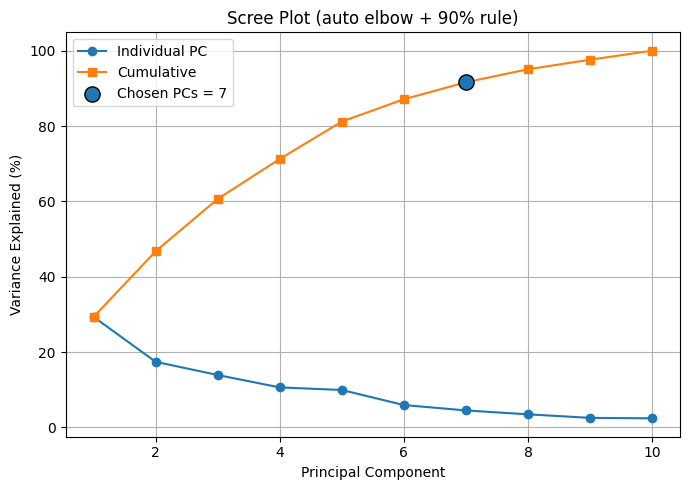

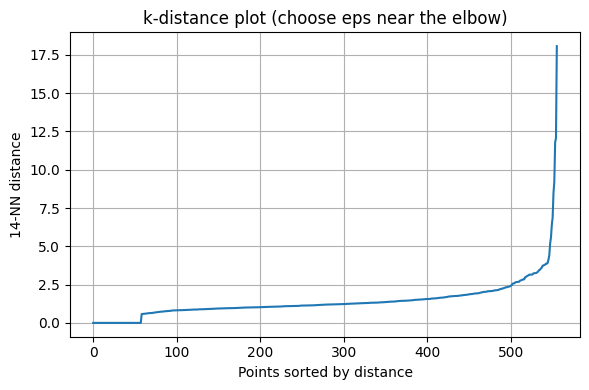

Chosen PCs: 7 (elbow=5, 90%=7)
DBSCAN eps≈2.214, min_samples=14
Clusters found: 1 | Noise fraction: 5.04% | Silhouette (non-noise): nan


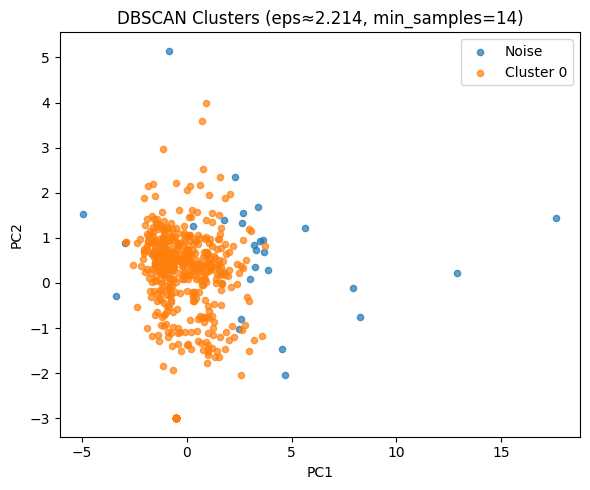

In [88]:
result = pca_dbscan_pipeline(X, min_samples=None, target_cumvar=0.90, show_plots=True, return_all=True)

labels = result['labels']
analysis_table['dbscan_label'] = -1
analysis_table.loc[X.index, 'dbscan_label'] = labels


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


DBSCAN+UMAP found 6 clusters
Silhouette: 0.35289955139160156


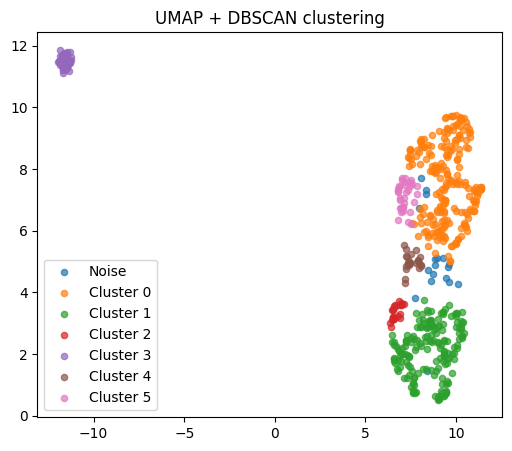

In [90]:
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# ---- Scale your features ----
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X.fillna(X.median()))

# ---- UMAP embedding ----
umap_embed = umap.UMAP(
    n_neighbors=15,   # controls local vs global structure
    min_dist=0.1,     # tighter clusters if smaller
    n_components=2,   # 2D embedding
    random_state=0
).fit_transform(X_scaled)

# ---- DBSCAN on UMAP space ----
db = DBSCAN(eps=0.5, min_samples=10).fit(umap_embed)
labels = db.labels_

# ---- Cluster stats ----
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"DBSCAN+UMAP found {n_clusters} clusters")
if n_clusters >= 2:
    print("Silhouette:", silhouette_score(umap_embed[labels!=-1], labels[labels!=-1]))

# ---- Visualization ----
plt.figure(figsize=(6,5))
for lab in sorted(set(labels)):
    m = labels == lab
    lbl = f"Cluster {lab}" if lab != -1 else "Noise"
    plt.scatter(umap_embed[m,0], umap_embed[m,1], s=20, alpha=0.7, label=lbl)
plt.legend()
plt.title("UMAP + DBSCAN clustering")
plt.show()


In [92]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

# Run DBSCAN
db = DBSCAN(eps=0.5, min_samples=10).fit(umap_embed)
labels = db.labels_  # -1 = noise

# Basic stats
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_frac = np.mean(labels == -1)
print(f"Clusters: {n_clusters}, Noise fraction: {noise_frac:.2%}")

# Optional silhouette score
if n_clusters >= 2:
    mask = labels != -1
    sil = silhouette_score(umap_embed[mask], labels[mask])
    print(f"Silhouette score: {sil:.3f}")


Clusters: 6, Noise fraction: 3.24%
Silhouette score: 0.353


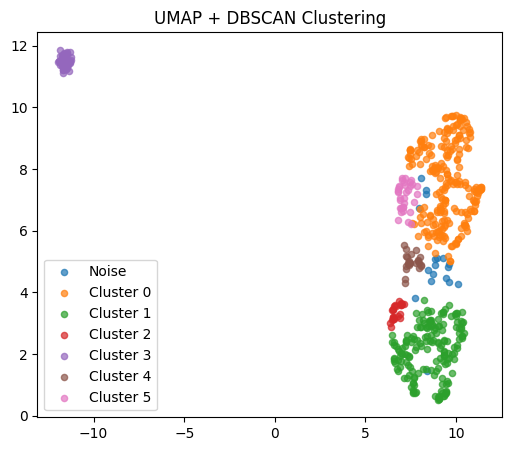

In [93]:
plt.figure(figsize=(6,5))
for lab in sorted(set(labels)):
    mask = labels == lab
    lbl = f"Cluster {lab}" if lab != -1 else "Noise"
    plt.scatter(umap_embed[mask,0], umap_embed[mask,1], s=20, alpha=0.7, label=lbl)
plt.legend()
plt.title("UMAP + DBSCAN Clustering")
plt.show()


In [91]:
from sklearn.manifold import TSNE

tsne_embed = TSNE(
    n_components=2, perplexity=30, random_state=0
).fit_transform(X_scaled)

# Optional clustering
db = DBSCAN(eps=2.0, min_samples=10).fit(tsne_embed)
labels = db.labels_


In [67]:
features = features.fillna(features.median())

In [68]:
corr = features.corr(method='pearson')

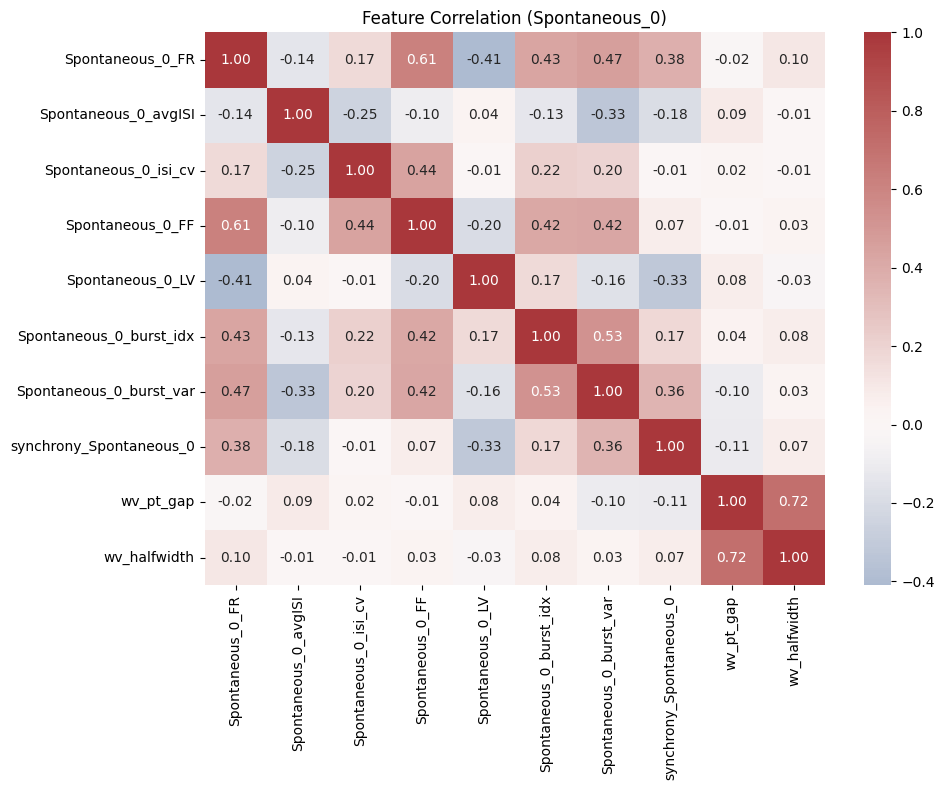

In [71]:
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0,
            xticklabels=feature_cols, yticklabels=feature_cols)
plt.title("Feature Correlation (Spontaneous_0)")
plt.tight_layout()
plt.show()


In [74]:
from sklearn.preprocessing import StandardScaler

# pick features you decided to keep (e.g. after correlation pruning)
X = features.copy()

# scale to mean=0, var=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [77]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional PCA to denoise / compress (recommended: keep 90–95% variance)
use_pca = True
if use_pca:
    pca = PCA(n_components=min(10, X_scaled.shape[1]))
    X_pca = pca.fit_transform(X_scaled)
    # pick number of PCs that hit ~90% variance
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    n_pc = int(np.searchsorted(cumvar, 0.90) + 1)
    X_embed = X_pca[:, :n_pc]
else:
    X_embed = X_scaled

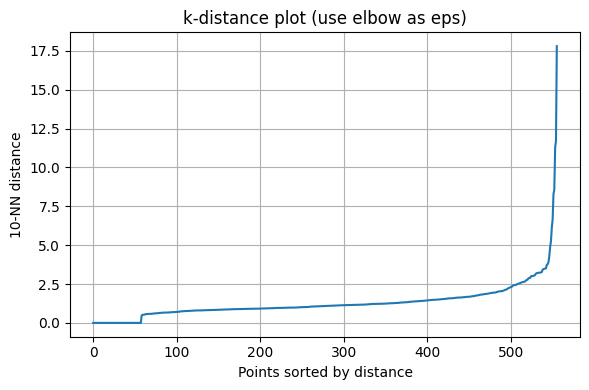

In [78]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

min_samples = 10  # common rule: ~ dimensionality*2, tune later
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_embed)
distances, _ = nbrs.kneighbors(X_embed)
k_dist = np.sort(distances[:, -1])  # distance to k-th neighbor

plt.figure(figsize=(6,4))
plt.plot(k_dist)
plt.ylabel(f'{min_samples}-NN distance')
plt.xlabel('Points sorted by distance')
plt.title('k-distance plot (use elbow as eps)')
plt.grid(True); plt.tight_layout(); plt.show()


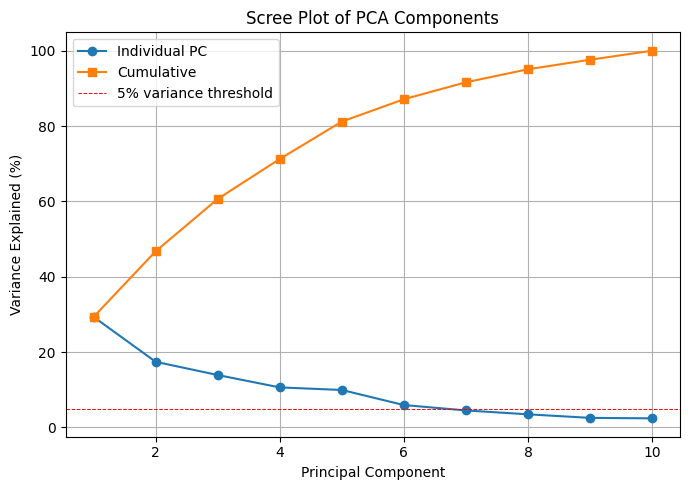

In [79]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ---- 1. Standardize features ----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)   # X = your selected feature DataFrame

# ---- 2. Run PCA ----
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# ---- 3. Explained variance ratios ----
explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

# ---- 4. Scree plot ----
plt.figure(figsize=(7,5))
plt.plot(range(1, len(explained_var)+1), explained_var*100, marker='o', label='Individual PC')
plt.plot(range(1, len(cum_explained_var)+1), cum_explained_var*100, marker='s', label='Cumulative')
plt.axhline(5, color='red', linestyle='--', linewidth=0.7, label='5% variance threshold')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('Scree Plot of PCA Components')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Elbow at PC 5 (cum.var = 81.2%)


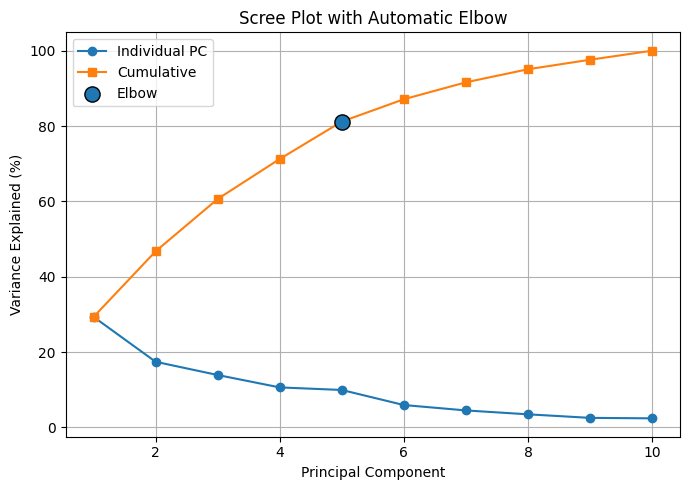

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1) Scale and PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X = your feature DataFrame
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_          # per-PC
cum_explained = np.cumsum(explained)               # cumulative

# 2) Elbow via max distance to straight line (first->last point)
x = np.arange(1, len(explained)+1)
y = cum_explained

# line through first & last points
p1 = np.array([x[0], y[0]])
p2 = np.array([x[-1], y[-1]])
line_vec = p2 - p1
line_vec = line_vec / np.linalg.norm(line_vec)

# distances
pts = np.vstack([x, y]).T
p1_to_pts = pts - p1
proj_len = p1_to_pts @ line_vec
proj_pts = p1 + np.outer(proj_len, line_vec)
dists = np.linalg.norm(pts - proj_pts, axis=1)

elbow_idx = int(np.argmax(dists))   # 0-based
n_pc_elbow = elbow_idx + 1          # PCs are 1-based for humans

print(f"Elbow at PC {n_pc_elbow} (cum.var = {cum_explained[elbow_idx]*100:.1f}%)")

# 3) Plot with elbow marker
plt.figure(figsize=(7,5))
plt.plot(x, explained*100, marker='o', label='Individual PC')
plt.plot(x, cum_explained*100, marker='s', label='Cumulative')
plt.scatter(n_pc_elbow, cum_explained[elbow_idx]*100, s=120, edgecolor='k', zorder=5, label='Elbow')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('Scree Plot with Automatic Elbow')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# 4) Use PCs up to the elbow (or min with 90% rule below)
X_embed = X_pca[:, :n_pc_elbow]


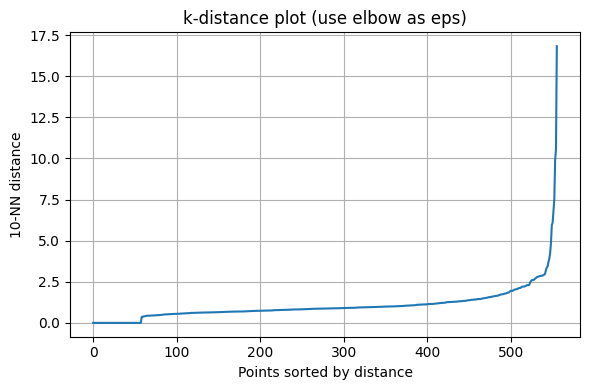

In [81]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

min_samples = 10  # common rule: ~ dimensionality*2, tune later
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X_embed)
distances, _ = nbrs.kneighbors(X_embed)
k_dist = np.sort(distances[:, -1])  # distance to k-th neighbor

plt.figure(figsize=(6,4))
plt.plot(k_dist)
plt.ylabel(f'{min_samples}-NN distance')
plt.xlabel('Points sorted by distance')
plt.title('k-distance plot (use elbow as eps)')
plt.grid(True); plt.tight_layout(); plt.show()


In [85]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps = float(input("Enter eps from k-distance elbow (e.g., 0.5): ") or 0.5)

db = DBSCAN(eps=eps, min_samples=min_samples)
labels = db.fit_predict(X_embed)  # -1 = noise

# Basic stats
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_frac = np.mean(labels == -1)

print(f'Clusters found: {n_clusters}')
print(f'Noise fraction: {noise_frac:.2%}')

# Silhouette on clustered points only (needs >= 2 clusters)
mask = labels != -1
if n_clusters >= 2 and np.sum(mask) > n_clusters:
    sil = silhouette_score(X_embed[mask], labels[mask])
    print(f'Silhouette (clustered points): {sil:.3f}')
else:
    print('Silhouette not defined (need >=2 clusters among non-noise).')

# Attach to table if useful
analysis_table['dbscan_label'] = -1
analysis_table.loc[X.index, 'dbscan_label'] = labels


Enter eps from k-distance elbow (e.g., 0.5):  0.4


Clusters found: 2
Noise fraction: 87.23%
Silhouette (clustered points): 0.976


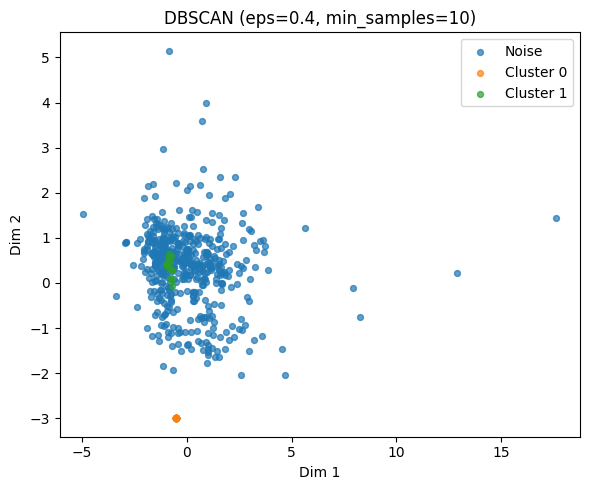

In [86]:
# 2D view: use first two PCs from X_embed or compute a 2D PCA just for plotting
if X_embed.shape[1] >= 2:
    plot_2d = X_embed[:, :2]
else:
    plot_2d = PCA(n_components=2).fit_transform(X_embed)

plt.figure(figsize=(6,5))
for lab in sorted(set(labels)):
    m = labels == lab
    lbl = f'Cluster {lab}' if lab != -1 else 'Noise'
    plt.scatter(plot_2d[m,0], plot_2d[m,1], s=18, alpha=0.7, label=lbl)
plt.legend()
plt.xlabel('Dim 1'); plt.ylabel('Dim 2')
plt.title(f'DBSCAN (eps={eps}, min_samples={min_samples})')
plt.tight_layout(); plt.show()


In [8]:
def calculate_FR(spike_times, bin_size=10, t_start=None, t_end=None):
    """ 
    Calculate spike counts and firing rate from time bins 
    
    Parameters 
    ----------
    spike_times : numpy.ndarray
        Time points when spikes occurred (in ms or sec — match bin_size units)
    bin_size : float
        Width of time bin (same units as spike_times)
    t_start : float, optional
        Start time of binning window. If None, inferred from spike_times.
    t_end : float, optional
        End time of binning window. If None, inferred from spike_times.
    
    Returns 
    -------
    spike_counts : numpy.ndarray
        Number of spikes in each time bin 
    bin_edges : numpy.ndarray
        Array of bin edge times 
    firing_rate : numpy.ndarray
        Firing rate in each bin (spikes/sec if bin_size is in ms)
    """
    spike_times = np.asarray(spike_times)

    # Infer t_start/t_end if not provided
    if t_start is None:
        t_start = np.floor(np.min(spike_times))
    if t_end is None:
        t_end = np.ceil(np.max(spike_times))

    # Create time bins
    time_bins = np.arange(t_start, t_end + bin_size, bin_size)

    # Count spikes
    spike_counts, bin_edges = np.histogram(spike_times, bins=time_bins)

    # Convert to firing rate (Hz)
    firing_rate = spike_counts / (bin_size)  # if bin_size in ms

    return spike_counts, bin_edges, firing_rate


In [10]:
def average_FR(bin_size, analysis_input, session_name):
    """ 
    Calculate spike counts and firing rate from time bins for all neurons from same session 
    
    Parameters 
    ----------
    bin_size : float
        Width of time bin (same units as spike_times)
    analysis_input : numpy.ndarray
        Time points when spikes occurred (in ms or sec — match bin_size units)
    session_name: string
        Which session to use
    
    Returns 
    -------
    spike_counts : numpy.ndarray
        Number of spikes in each time bin for all neurons
    """
    
    analysis_table = analysis_input
    t_start = stimulus_table.loc[stimulus_table['stim_name'] == session_name, 'start_time'].item()
    t_stop  = stimulus_table.loc[stimulus_table['stim_name'] == session_name, 'stop_time'].item()
    
    # Container to store results
    firing_rate_matrix= []  # each row: 1 unit's firing rate across time bins

    for unit_idx in range(len(analysis_table)):
        spike_times = analysis_table.iloc[unit_idx][session_name+'_spikes']

        # Skip empty entries
        if spike_times is None or len(spike_times) == 0:
            continue

        # Ensure numpy array & filter to stimulus window
        spike_times = np.asarray(spike_times)
        spike_times = spike_times[(spike_times >= t_start) & (spike_times <= t_stop-10)]

        # Compute binned firing rate
        spike_counts, bin_edges, firing_rate = calculate_FR(
            spike_times, bin_size=bin_size, t_start=t_start, t_end=t_stop-10
        )

        firing_rate_matrix.append(firing_rate)

    # Convert to numpy array
    firing_rate_matrix= np.array(firing_rate_matrix)  # shape: [units x time_bins]

    print("Firing rate matrix shape:", firing_rate_matrix.shape)
    fr_matrix_trimmed = firing_rate_matrix[:, :-1]
    # fr_matrix shape: (n_neurons, n_time_bins)
    z_fr_matrix = zscore(fr_matrix_trimmed, axis=1)

    # Compute correlation matrix across neurons
    correlation_matrix = np.corrcoef(z_fr_matrix)
    return correlation_matrix

In [11]:
firing_rate_matrix_spon0 = average_FR(10, analysis_table, 'Spontaneous_0')
firing_rate_matrix_spon1 = average_FR(10, analysis_table, 'Spontaneous_1')

Firing rate matrix shape: (498, 120)
Firing rate matrix shape: (545, 120)


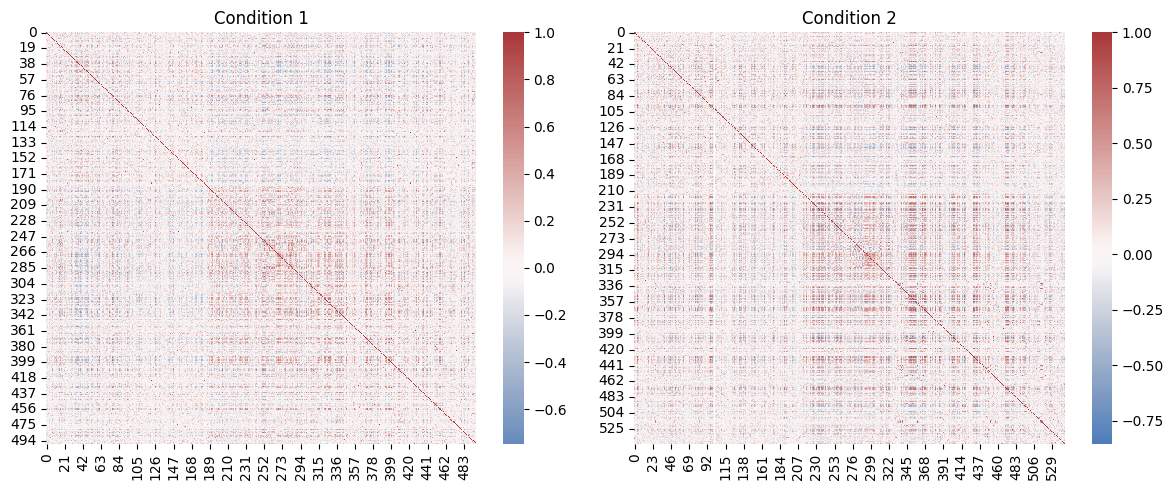

In [12]:
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First correlation matrix
sns.heatmap(firing_rate_matrix_spon0 , ax=axes[0], cmap='vlag', center=0)
axes[0].set_title("Condition 1")

# Second correlation matrix
sns.heatmap(firing_rate_matrix_spon1, ax=axes[1], cmap='vlag', center=0)
axes[1].set_title("Condition 2")

plt.tight_layout()
plt.show()

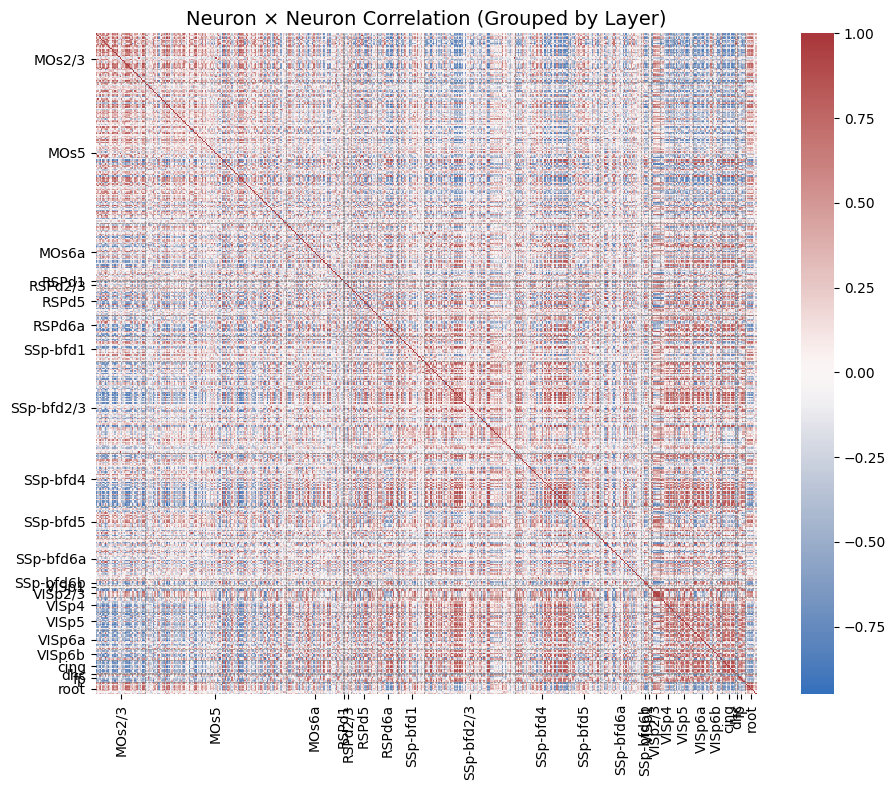

In [13]:
# 1. Get layer info
layers = []
for unit_idx in range(len(analysis_table)):
    spike_times = analysis_table.iloc[unit_idx]['Spontaneous_0_spikes']
    if spike_times is None or len(spike_times) == 0:
        continue
    layers.append(analysis_table.iloc[unit_idx]['layer'])

layers = np.array(layers)
fr_matrix = firing_rate_matrix_spon0.copy()

# 2. Sort neurons by layer
sorted_indices = np.argsort(layers)
sorted_layers = layers[sorted_indices]
fr_matrix_sorted = fr_matrix[sorted_indices]

# 3. Compute correlation matrix
corr_matrix = np.corrcoef(fr_matrix_sorted)

# 4. Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='vlag', center=0, square=True, xticklabels=False, yticklabels=False)
plt.title("Neuron × Neuron Correlation (Grouped by Layer)", fontsize=14)

# 5. Optionally draw lines to show layer boundaries
unique_layers, counts = np.unique(sorted_layers, return_counts=True)
layer_boundaries = np.cumsum(counts)

# Draw horizontal and vertical lines to separate layers
for boundary in layer_boundaries[:-1]:
    plt.axhline(boundary, color='gray', linestyle='--', linewidth=0.5)
    plt.axvline(boundary, color='gray', linestyle='--', linewidth=0.5)

# 6. Compute tick positions (center of each group)
tick_positions = layer_boundaries - counts // 2

# ✅ Fix: Make sure tick_positions and labels match in length
assert len(tick_positions) == len(unique_layers)

# Add layer labels
plt.yticks(tick_positions, unique_layers, fontsize=10)
plt.xticks(tick_positions, unique_layers, fontsize=10, rotation=90)

plt.tight_layout()
plt.show()


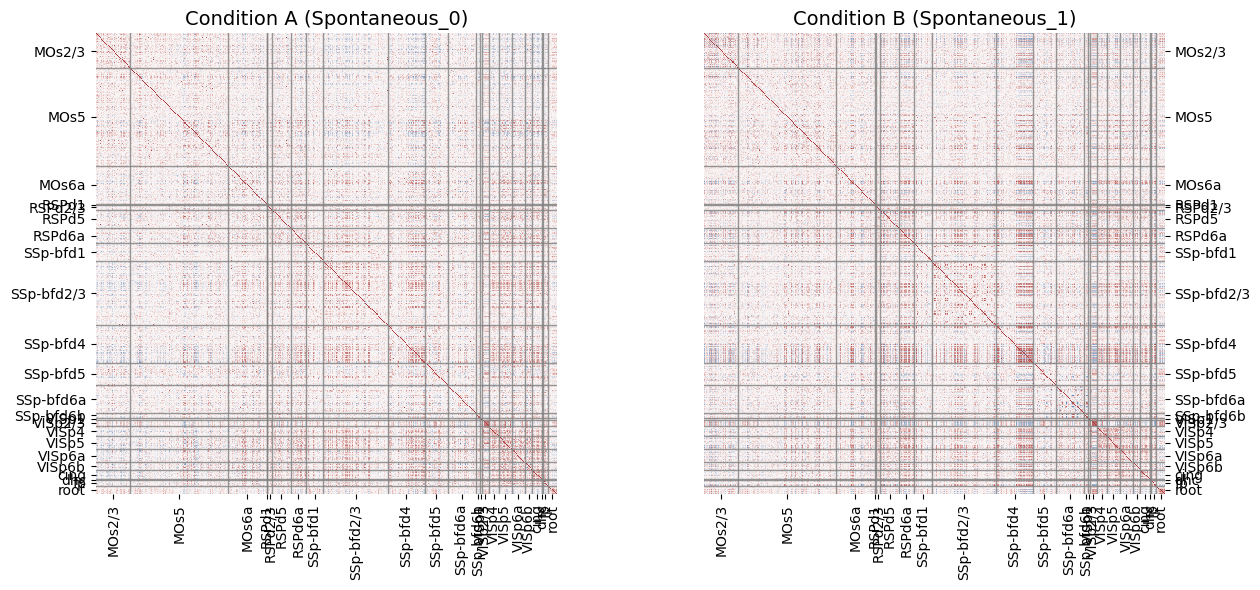

In [14]:
# ---- 0) Build per-condition FR matrices with SAME units ----
# Collect per-unit data and keep only units that are valid in BOTH conditions
valid_idx = []
layers_all = []
fr0 = []  # Spontaneous_0 per-unit FR vectors
fr1 = []  # RFMapping_0 (or whatever) per-unit FR vectors

for unit_idx in range(len(analysis_table)):
    layer = analysis_table.iloc[unit_idx]['layer']

    st0 = analysis_table.iloc[unit_idx].get('Spontaneous_0_spikes', [])
    st1 = analysis_table.iloc[unit_idx].get('Spontaneous_1_spikes', [])

    if layer is None or st0 is None or st1 is None or len(st0) == 0 or len(st1) == 0:
        continue

    st0 = np.asarray(st0)
    st1 = np.asarray(st1)

    # windows for each condition (adjust names if needed)
    t0_start = stimulus_table.loc[stimulus_table['stim_name'] == 'Spontaneous_0', 'start_time'].item()
    t0_stop  = stimulus_table.loc[stimulus_table['stim_name'] == 'Spontaneous_0', 'stop_time'].item()

    t1_start = stimulus_table.loc[stimulus_table['stim_name'] == 'Spontaneous_1', 'start_time'].item()
    t1_stop  = stimulus_table.loc[stimulus_table['stim_name'] == 'Spontaneous_1', 'stop_time'].item()

    # (optional) drop last 10 s:
    t0_stop_adj = t0_stop - 10
    t1_stop_adj = t1_stop - 10

    st0 = st0[(st0 >= t0_start) & (st0 <= t0_stop_adj)]
    st1 = st1[(st1 >= t1_start) & (st1 <= t1_stop_adj)]
    if len(st0) == 0 or len(st1) == 0:
        continue

    # compute FR with same binning lengths
    bin_size = 10  # seconds or ms—match your units
    _, be0, fr_vec0 = calculate_FR(st0, bin_size=bin_size, t_start=t0_start, t_end=t0_stop_adj)
    _, be1, fr_vec1 = calculate_FR(st1, bin_size=bin_size, t_start=t1_start, t_end=t1_stop_adj)

    # require matching number of bins across units for each condition
    # (skip units that end up with different-length vectors—rare if windows consistent)
    if fr0 and (len(fr_vec0) != len(fr0[0]) or len(fr_vec1) != len(fr1[0])):
        continue

    # skip zero-variance (flat) units to avoid NaNs in corr
    if np.std(fr_vec0) == 0 or np.std(fr_vec1) == 0:
        continue

    valid_idx.append(unit_idx)
    layers_all.append(layer)
    fr0.append(fr_vec0)
    fr1.append(fr_vec1)

fr0 = np.array(fr0)  # shape: [n_units, n_bins0]
fr1 = np.array(fr1)  # shape: [n_units, n_bins1]
layers_all = np.array(layers_all)

# ---- 1) Common sorting by LAYER for both matrices ----
sorted_idx = np.argsort(layers_all)
sorted_layers = layers_all[sorted_idx]
fr0_sorted = fr0[sorted_idx]
fr1_sorted = fr1[sorted_idx]

# ---- 2) Correlation matrices with same unit order ----
corr0 = np.corrcoef(fr0_sorted)
corr1 = np.corrcoef(fr1_sorted)

# ---- 3) Shared boundaries/ticks from the same sorted_layers ----
unique_layers, counts = np.unique(sorted_layers, return_counts=True)
layer_boundaries = np.cumsum(counts)                 # e.g., [nL23, nL23+nL4, ...]
tick_positions = layer_boundaries - counts/2.0       # centers

# ---- 4) Plot side by side using the same boundaries/ticks ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# ensure arrays for safety
tick_positions = np.asarray(tick_positions, dtype=float)
unique_layers = list(unique_layers)

for ax, (mat, title) in zip(
    axes,
    [(corr0, "Condition A (Spontaneous_0)"),
     (corr1, "Condition B (Spontaneous_1)")]
):
    # Draw heatmap (do NOT pass yticklabels=True/False here; we will set them explicitly)
    sns.heatmap(mat, cmap='vlag', center=0, square=True,
                xticklabels=False, yticklabels=False, ax=ax, cbar=False)

    ax.set_title(title, fontsize=14)

    # Layer boundaries
    for b in layer_boundaries[:-1]:
        ax.axhline(b, color='gray', linestyle='-', linewidth=1.0, alpha=0.8)
        ax.axvline(b, color='gray', linestyle='-', linewidth=1.0, alpha=0.8)

    # X ticks (centers of groups) for both plots
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(unique_layers, fontsize=10, rotation=90)

# --- Y ticks / labels ---
# Left plot: labels on the LEFT
axes[0].set_yticks(tick_positions)
axes[0].set_yticklabels(unique_layers, fontsize=10)
axes[0].tick_params(axis='y', labelleft=True, labelright=False)

# Right plot: labels on the RIGHT
axes[1].set_yticks(tick_positions)
axes[1].set_yticklabels(unique_layers, fontsize=10)
axes[1].yaxis.tick_right()
axes[1].tick_params(axis='y', labelright=True, labelleft=False)

# (Paranoia) Ensure labels are visible even with shared axes
for ax in axes:
    for lab in ax.get_yticklabels():
        lab.set_visible(True)

plt.tight_layout()
plt.show()


In [15]:
# Select psilocybin sessions 
filtered_metadata = metadata[metadata.session_type == 'saline']

# Get the asset name 
session_name = filtered_metadata['name'].iloc[0]

# Find the filepath 
data_dir = os.path.join(r'/data/np-ultra-psychedelics/', session_name)
nwb_path_zarr = list(Path(data_dir).glob("*.nwb"))[0]

print('Found filepath:', nwb_path_zarr) 

Found filepath: /data/np-ultra-psychedelics/ecephys_714527_2024-05-14_13-22-07_nwb_2025-08-03_21-11-22/ecephys_714527_2024-05-14_13-22-07_experiment1_recording1.nwb


In [16]:
io = NWBZarrIO(nwb_path_zarr, mode = 'r') 
nwbfile_zarr = io.read()

In [56]:
stimulus = nwbfile_zarr.stimulus
stimulus_table = stimulus['epochs'][:]
units = nwbfile_zarr.units[:]

In [57]:
analysis = nwbfile_zarr.analysis
analysis_table = analysis['analysis_table'][:]

In [58]:
firing_rate_matrix_spon0 = average_FR(10, analysis_table, 'Spontaneous_0')
firing_rate_matrix_spon1 = average_FR(10, analysis_table, 'Spontaneous_1')

Firing rate matrix shape: (334, 120)
Firing rate matrix shape: (345, 120)


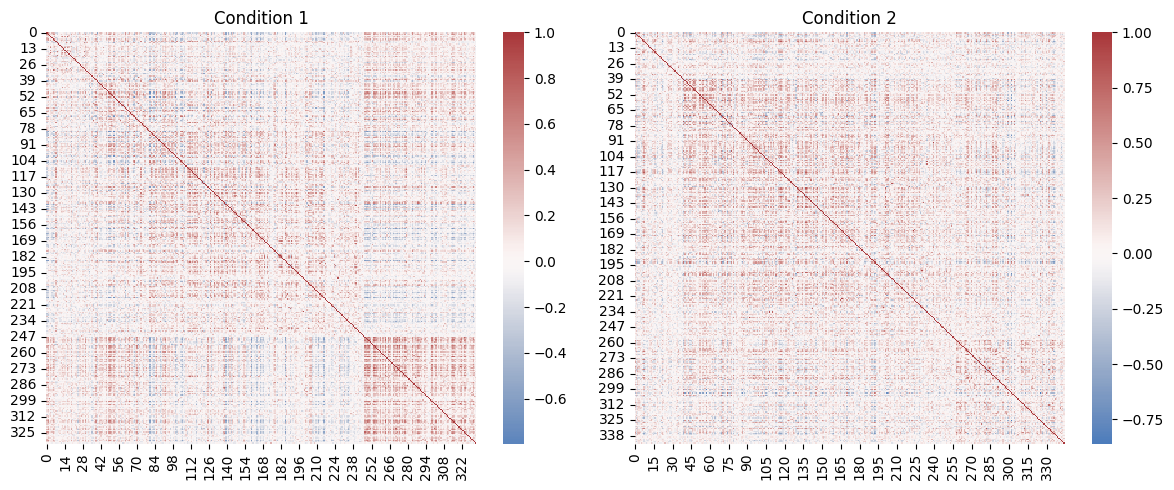

In [59]:
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First correlation matrix
sns.heatmap(firing_rate_matrix_spon0, ax=axes[0], cmap='vlag', center=0)
axes[0].set_title("Condition 1")

# Second correlation matrix
sns.heatmap(firing_rate_matrix_spon1, ax=axes[1], cmap='vlag', center=0)
axes[1].set_title("Condition 2")

plt.tight_layout()
plt.show()

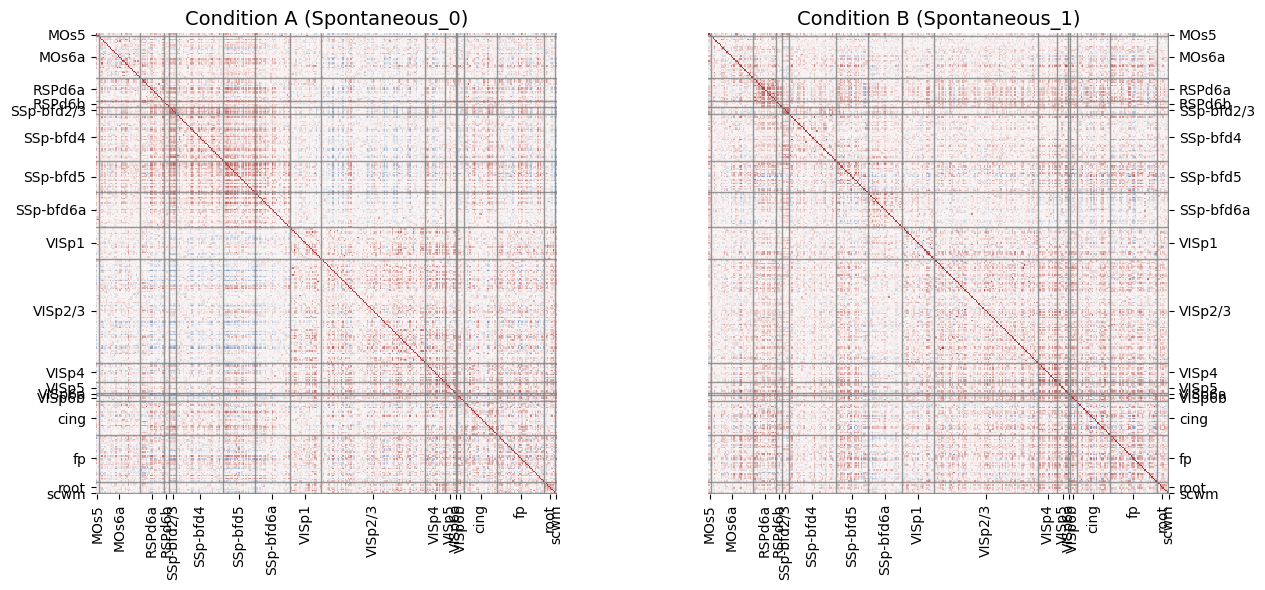

In [60]:
# ---- 0) Build per-condition FR matrices with SAME units ----
# Collect per-unit data and keep only units that are valid in BOTH conditions
valid_idx = []
layers_all = []
fr0 = []  # Spontaneous_0 per-unit FR vectors
fr1 = []  # RFMapping_0 (or whatever) per-unit FR vectors

for unit_idx in range(len(analysis_table)):
    layer = analysis_table.iloc[unit_idx]['layer']

    st0 = analysis_table.iloc[unit_idx].get('Spontaneous_0_spikes', [])
    st1 = analysis_table.iloc[unit_idx].get('Spontaneous_1_spikes', [])

    if layer is None or st0 is None or st1 is None or len(st0) == 0 or len(st1) == 0:
        continue

    st0 = np.asarray(st0)
    st1 = np.asarray(st1)

    # windows for each condition (adjust names if needed)
    t0_start = stimulus_table.loc[stimulus_table['stim_name'] == 'Spontaneous_0', 'start_time'].item()
    t0_stop  = stimulus_table.loc[stimulus_table['stim_name'] == 'Spontaneous_0', 'stop_time'].item()

    t1_start = stimulus_table.loc[stimulus_table['stim_name'] == 'Spontaneous_1', 'start_time'].item()
    t1_stop  = stimulus_table.loc[stimulus_table['stim_name'] == 'Spontaneous_1', 'stop_time'].item()

    # (optional) drop last 10 s:
    t0_stop_adj = t0_stop - 10
    t1_stop_adj = t1_stop - 10

    st0 = st0[(st0 >= t0_start) & (st0 <= t0_stop_adj)]
    st1 = st1[(st1 >= t1_start) & (st1 <= t1_stop_adj)]
    if len(st0) == 0 or len(st1) == 0:
        continue

    # compute FR with same binning lengths
    bin_size = 10  # seconds or ms—match your units
    _, be0, fr_vec0 = calculate_FR(st0, bin_size=bin_size, t_start=t0_start, t_end=t0_stop_adj)
    _, be1, fr_vec1 = calculate_FR(st1, bin_size=bin_size, t_start=t1_start, t_end=t1_stop_adj)

    # require matching number of bins across units for each condition
    # (skip units that end up with different-length vectors—rare if windows consistent)
    if fr0 and (len(fr_vec0) != len(fr0[0]) or len(fr_vec1) != len(fr1[0])):
        continue

    # skip zero-variance (flat) units to avoid NaNs in corr
    if np.std(fr_vec0) == 0 or np.std(fr_vec1) == 0:
        continue

    valid_idx.append(unit_idx)
    layers_all.append(layer)
    fr0.append(fr_vec0)
    fr1.append(fr_vec1)

fr0 = np.array(fr0)  # shape: [n_units, n_bins0]
fr1 = np.array(fr1)  # shape: [n_units, n_bins1]
layers_all = np.array(layers_all)

# ---- 1) Common sorting by LAYER for both matrices ----
sorted_idx = np.argsort(layers_all)
sorted_layers = layers_all[sorted_idx]
fr0_sorted = fr0[sorted_idx]
fr1_sorted = fr1[sorted_idx]

# ---- 2) Correlation matrices with same unit order ----
corr0 = np.corrcoef(fr0_sorted)
corr1 = np.corrcoef(fr1_sorted)

# ---- 3) Shared boundaries/ticks from the same sorted_layers ----
unique_layers, counts = np.unique(sorted_layers, return_counts=True)
layer_boundaries = np.cumsum(counts)                 # e.g., [nL23, nL23+nL4, ...]
tick_positions = layer_boundaries - counts/2.0       # centers

# ---- 4) Plot side by side using the same boundaries/ticks ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# ensure arrays for safety
tick_positions = np.asarray(tick_positions, dtype=float)
unique_layers = list(unique_layers)

for ax, (mat, title) in zip(
    axes,
    [(corr0, "Condition A (Spontaneous_0)"),
     (corr1, "Condition B (Spontaneous_1)")]
):
    # Draw heatmap (do NOT pass yticklabels=True/False here; we will set them explicitly)
    sns.heatmap(mat, cmap='vlag', center=0, square=True,
                xticklabels=False, yticklabels=False, ax=ax, cbar=False)

    ax.set_title(title, fontsize=14)

    # Layer boundaries
    for b in layer_boundaries[:-1]:
        ax.axhline(b, color='gray', linestyle='-', linewidth=1.0, alpha=0.8)
        ax.axvline(b, color='gray', linestyle='-', linewidth=1.0, alpha=0.8)

    # X ticks (centers of groups) for both plots
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(unique_layers, fontsize=10, rotation=90)

# --- Y ticks / labels ---
# Left plot: labels on the LEFT
axes[0].set_yticks(tick_positions)
axes[0].set_yticklabels(unique_layers, fontsize=10)
axes[0].tick_params(axis='y', labelleft=True, labelright=False)

# Right plot: labels on the RIGHT
axes[1].set_yticks(tick_positions)
axes[1].set_yticklabels(unique_layers, fontsize=10)
axes[1].yaxis.tick_right()
axes[1].tick_params(axis='y', labelright=True, labelleft=False)

# (Paranoia) Ensure labels are visible even with shared axes
for ax in axes:
    for lab in ax.get_yticklabels():
        lab.set_visible(True)

plt.tight_layout()
plt.show()


In [ ]:
# duration of action potential, slope of the waveform (derived fromwaveform), bursts of spikes, spike time dynamics

In [ ]:
# amplitude 

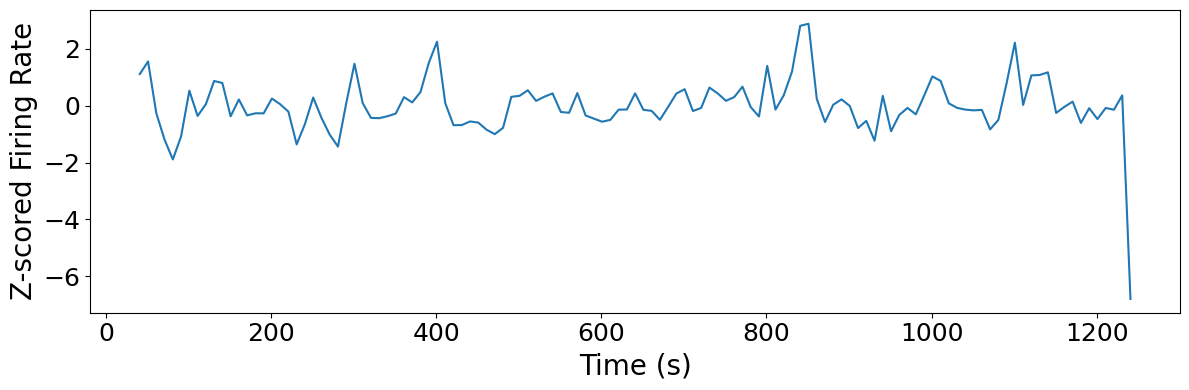

In [139]:
# Plot the firing rate for a single unit across the session
fig,ax = plt.subplots(figsize=(12,4))

ax.plot(bin_edges[:-1], z_score(avg_firing_rate))
        
ax.tick_params(axis='y',which='major',reset=True,right=False,labelsize=18)
ax.tick_params(axis='x',which='major',reset=True,top=False,labelsize=18)
ax.set_xlabel('Time (s)',fontsize=20)
ax.set_ylabel('Z-scored Firing Rate',fontsize=20)

fig.tight_layout()

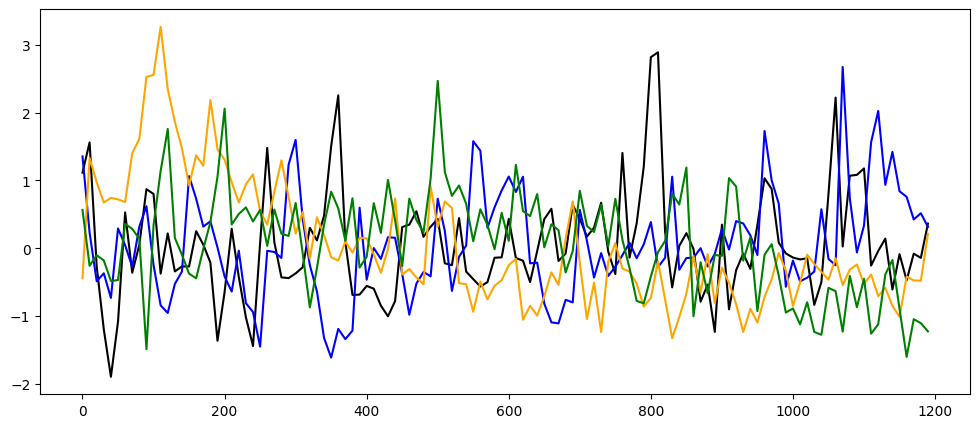

In [190]:
stim_conditions = ['Spontaneous_0_spikes', 'RFMapping_0_spikes', 'Spontaneous_1_spikes', 'RFMapping_1_spikes']
colors = ['black', 'blue', 'orange', 'green']  # one color per condition
labels = ['Spontaneous_0', 'RFMapping_0', 'Spontaneous_1', 'RFMapping_1']

bin_size = 10  # s

plt.figure(figsize=(12, 5))

for condition, color, label in zip(stim_conditions, colors, labels):

    # 1. Get start and stop times
    stim_row = stimulus_table[stimulus_table['stim_name'].str.contains(label)]
    if stim_row.empty:
        print(f"⚠️ Could not find time window for condition '{condition}'")
        continue
    
    t_start = stim_row['start_time'].iloc[0]
    t_stop  = stim_row['stop_time'].iloc[0]

    # 2. Firing rate matrix for this condition
    fr_matrix = []

    for unit_idx in range(len(analysis_table)):
        spike_times = analysis_table.iloc[unit_idx].get(condition, [])

        if spike_times is None or len(spike_times) == 0:
            continue

        spike_times = np.asarray(spike_times)
        spike_times = spike_times[(spike_times >= t_start) & (spike_times <= t_stop)]

        _, bin_edges, firing_rate = calculate_FR(spike_times, bin_size=bin_size, t_start=t_start, t_end=t_stop)
        fr_matrix.append(firing_rate)

    if not fr_matrix:
        print(f"No valid units found for condition '{condition}'")
        continue

    fr_matrix = np.array(fr_matrix)
    avg_fr = np.mean(fr_matrix, axis=0)
    avg_fr_z = z_score(avg_fr)

    # 3. Plot
    relative_time = bin_edges[:-1] - bin_edges[0]  # shift time to start from 0
    plt.plot(relative_time[:-1], avg_fr_z[:-1], label=label, color=color)


In [140]:
len(qual_checked_units['ks_unit_id'].unique())

ks_unit_id probe                      probe_type  \
id                                                      
350           1     A  Neuropixels Ultra (Switchable)   
351           2     A  Neuropixels Ultra (Switchable)   
352           3     A  Neuropixels Ultra (Switchable)   
353           4     A  Neuropixels Ultra (Switchable)   
354           5     A  Neuropixels Ultra (Switchable)   

                                  Spontaneous_0_spikes  \
id                                                       
350  [41.11226992833221, 41.3126363738815, 41.31283...   
351  [43.51170061373816, 73.44483424725053, 83.9988...   
352  [41.37910296719798, 59.87144922636121, 73.4770...   
353  [41.006003378937564, 41.028736687183226, 41.04...   
354  [86.90411939405645, 147.6591856802338, 179.421...   

                                  Spontaneous_1_spikes  \
id                                                       
350  [2846.700373779901, 2846.903873555326, 2847.07...   
351  [2929.772915437297, 2929.946315245939, 3028.47...   
352  [2911.620335469846, 2954.582488058324, 2960.69...   
353  [2846.310140877215, 2846.3254741936266, 2846.3...   
354  [3348.0570871669183, 3410.4427849869217, 3650....   

                                  Spontaneous_2_spikes  Spontaneous_3_spikes  \
id                                                                             
350  [5523.563186354844, 5523.772719456943, 5525.56...                   NaN   
351  [5525.498517552413, 5530.011012572582, 5531.70...                   NaN   
352  [5531.838343889337, 5578.430625805066, 5623.63...                   NaN   
353  [5522.315921064615, 5522.396220975999, 5522.59...                   NaN   
354  [5647.04928341326, 5647.519949560517, 5686.992...                   NaN   

     Spontaneous_4_spikes                                 RFMapping_0_spikes  \
id                                                                             
350                   NaN  [1254.011364748851, 1255.1815634574607, 1257.1...   
351                   NaN  [1303.9912762594438, 1416.535052060088, 1511.8...   
352                   NaN  [1313.877898682248, 1451.1992804725305, 1459.4...   
353                   NaN  [1253.6788651157858, 1253.7315650576281, 1253....   
354                   NaN  [1265.0223525975118, 1265.3398189138338, 1288....   

                                    RFMapping_1_spikes  ... optotagged  \
id                                                      ...              
350  [4058.995569266862, 4066.4692276858614, 4079.4...  ...          0   
351  [4080.6092454147683, 4235.196274817956, 4295.7...  ...          0   
352  [4066.7330273947414, 4087.219038120433, 4117.8...  ...          0   
353  [4058.8611027485877, 4058.8797360613576, 4058....  ...          0   
354  [4440.927181113891, 4503.954878225406, 5197.83...  ...          0   

     cell_type      spread bAP_extent bAP_attenuation    bAP_idx  burst_idx  \
id                                                                            
350         RS  379.743122      294.0        0.948508  15.454996   0.000077   
351         RS  374.245220      276.0        0.946755  15.217587   0.000000   
352         RS  503.960052      348.0        0.945747  18.880100   0.000000   
353        FSl  336.366188      288.0        0.948941  14.712279   0.000980   
354         RS  359.901768      300.0        0.949907  15.112158   0.000000   

     num_bursts burst_dur burst_proportion  
id                                          
350           2  0.004500         0.000231  
351           0       NaN         0.000000  
352           0       NaN         0.000000  
353         157  0.006001         0.002977  
354           0       NaN         0.000000  

[5 rows x 44 columns]

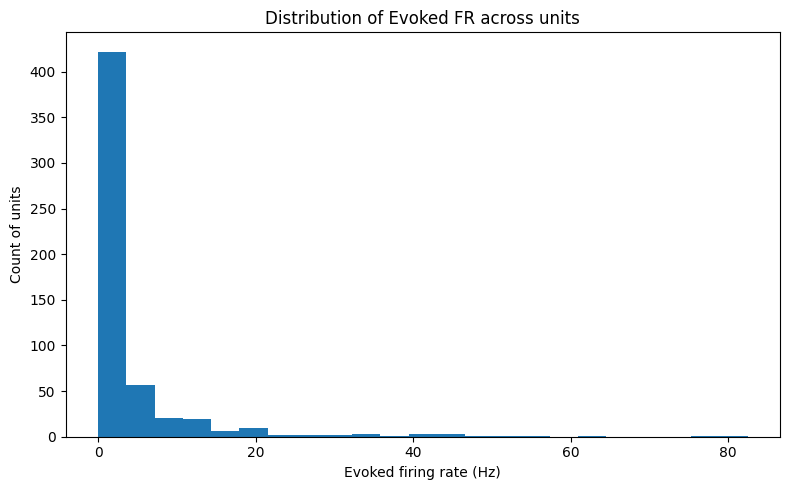

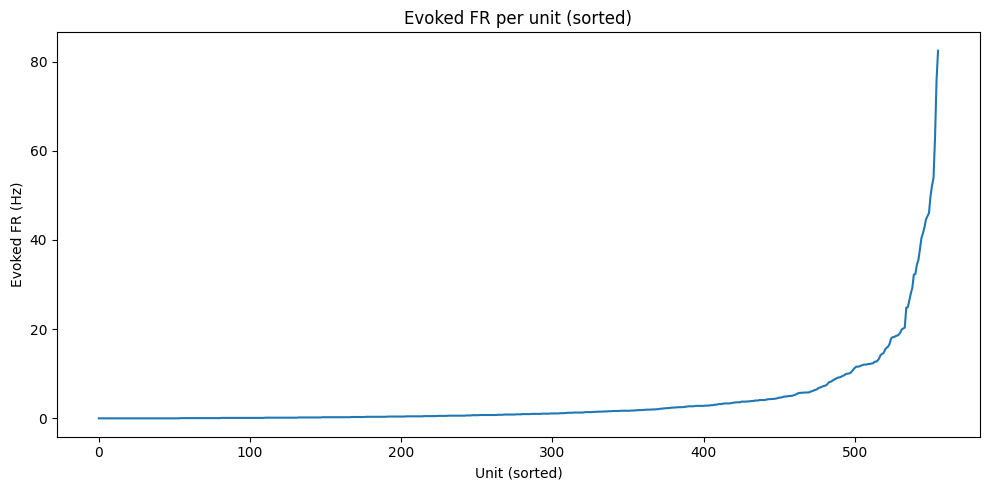

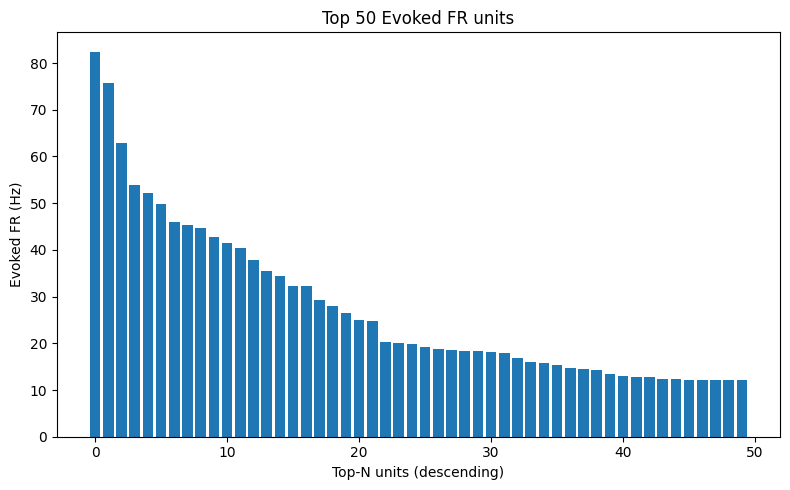

/tmp/ipykernel_73/1471968396.py:97: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



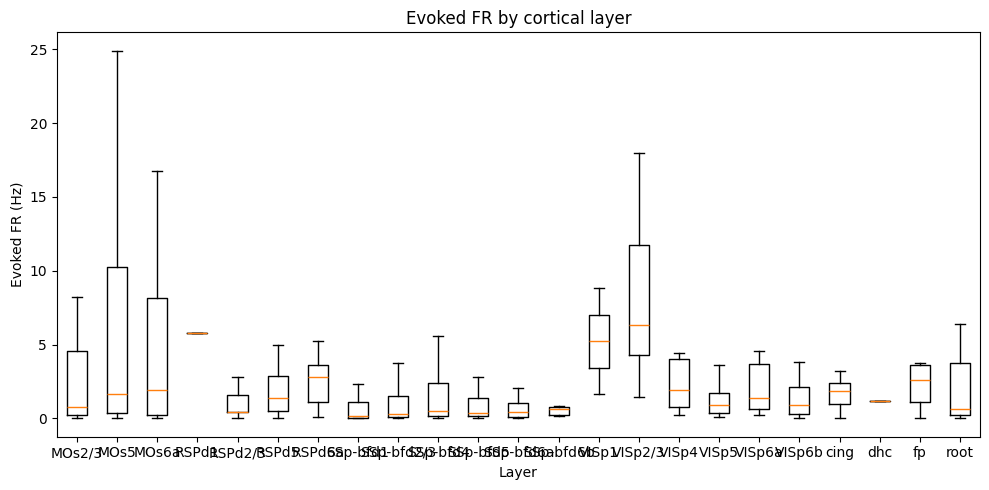

/tmp/ipykernel_73/1471968396.py:109: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



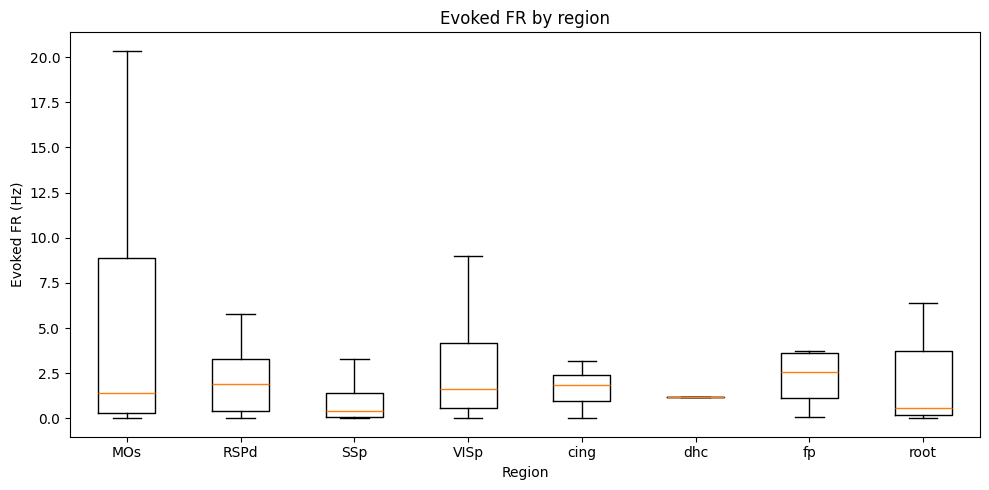

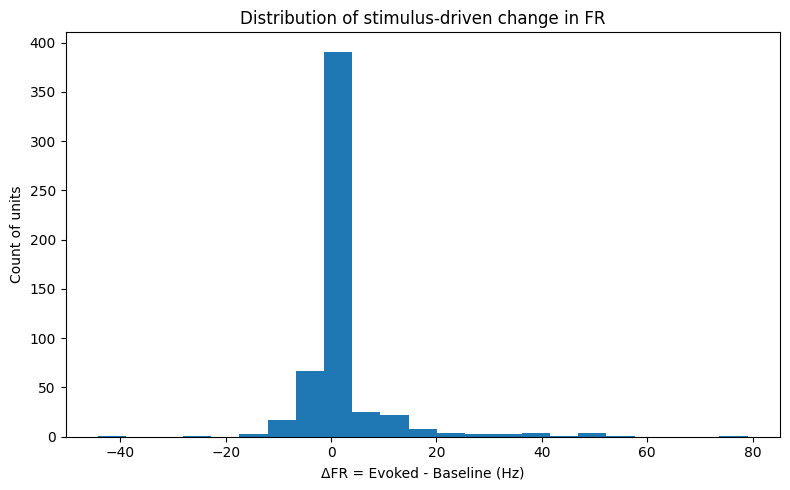

In [141]:
import math


df = pd.DataFrame(analysis_table)  # ensure it's a DataFrame; noop if already is

# ---------- Helpers ----------
def _to_1d_array(x):
    """
    Convert one cell value to a float if possible:
    - If it's already a float/int -> return as float
    - If it's a 1-length list/array -> return that single value
    - Otherwise -> np.nan
    """
    if x is None:
        return np.nan
    if isinstance(x, (int, float, np.number)):
        return float(x)
    # Handle object like [value] or np.array([value])
    try:
        arr = np.array(x)
        if arr.ndim == 0:
            return float(arr)
        if arr.ndim == 1 and arr.size == 1:
            return float(arr[0])
    except Exception:
        pass
    # If it's already a scalar-like string that can be cast:
    try:
        return float(x)
    except Exception:
        return np.nan

def series_to_numeric(series):
    """Safely coerce a column that may contain VectorData/object scalars to a numeric 1D float array."""
    return series.apply(_to_1d_array).astype(float)

# ---------- Extract core columns ----------
if 'evoked_FR' not in df.columns:
    raise KeyError("Column 'evoked_FR' not found in analysis_table.")

evoked = series_to_numeric(df['evoked_FR'])
baseline = series_to_numeric(df['baseline_FR']) if 'baseline_FR' in df.columns else pd.Series(np.nan, index=df.index)

# ΔFR (optional, used for one of the plots)
delta_fr = evoked - baseline

# Metadata (optional)
layer = df['layer'] if 'layer' in df.columns else pd.Series(['NA']*len(df), index=df.index, dtype=object)
region = df['region'] if 'region' in df.columns else pd.Series(['NA']*len(df), index=df.index, dtype=object)

# Combine into a tidy DataFrame
T = pd.DataFrame({
    'evoked_FR': evoked,
    'baseline_FR': baseline,
    'delta_FR': delta_fr,
    'layer': layer.astype(str),
    'region': region.astype(str),
})
T = T.replace([np.inf, -np.inf], np.nan).dropna(subset=['evoked_FR'])

# ---------- 1) Distribution of evoked firing rates ----------
plt.figure(figsize=(8,5))
vals = T['evoked_FR'].values
nbins = max(15, min(60, int(np.sqrt(len(vals)))))  # simple bin heuristic
plt.hist(vals, bins=nbins)
plt.xlabel('Evoked firing rate (Hz)')
plt.ylabel('Count of units')
plt.title('Distribution of Evoked FR across units')
plt.tight_layout()
plt.show()

# ---------- 2) Sorted per-unit evoked FR (top-N focus) ----------
plt.figure(figsize=(10,5))
sorted_vals = np.sort(vals)
plt.plot(sorted_vals)
plt.xlabel('Unit (sorted)')
plt.ylabel('Evoked FR (Hz)')
plt.title('Evoked FR per unit (sorted)')
plt.tight_layout()
plt.show()

# Optional zoom-in on top-N
N = min(50, len(sorted_vals))
plt.figure(figsize=(8,5))
plt.bar(np.arange(N), sorted_vals[::-1][:N])
plt.xlabel('Top-N units (descending)')
plt.ylabel('Evoked FR (Hz)')
plt.title(f'Top {N} Evoked FR units')
plt.tight_layout()
plt.show()

# ---------- 3) Boxplots by layer (if available) ----------
layers = [l for l in sorted(T['layer'].unique()) if l.lower() != 'na']
if len(layers) >= 2:  # only plot if meaningful variety
    data = [T.loc[T['layer']==l, 'evoked_FR'].dropna().values for l in layers]
    plt.figure(figsize=(10,5))
    plt.boxplot(data, labels=layers, showfliers=False)
    plt.xlabel('Layer')
    plt.ylabel('Evoked FR (Hz)')
    plt.title('Evoked FR by cortical layer')
    plt.tight_layout()
    plt.show()

# ---------- 4) Boxplots by region (if available) ----------
regions = [r for r in sorted(T['region'].unique()) if r.lower() != 'na']
if len(regions) >= 2:
    data = [T.loc[T['region']==r, 'evoked_FR'].dropna().values for r in regions]
    plt.figure(figsize=(10,5))
    plt.boxplot(data, labels=regions, showfliers=False)
    plt.xlabel('Region')
    plt.ylabel('Evoked FR (Hz)')
    plt.title('Evoked FR by region')
    plt.tight_layout()
    plt.show()

# ---------- 5) Optional: ΔFR = evoked - baseline distribution ----------
if T['baseline_FR'].notna().any():
    plt.figure(figsize=(8,5))
    d = T['delta_FR'].dropna().values
    nbins = max(15, min(60, int(np.sqrt(len(d)))))
    plt.hist(d, bins=nbins)
    plt.xlabel('ΔFR = Evoked - Baseline (Hz)')
    plt.ylabel('Count of units')
    plt.title('Distribution of stimulus-driven change in FR')
    plt.tight_layout()
    plt.show()


Matrix shape (stimuli × neurons): (4, 556)


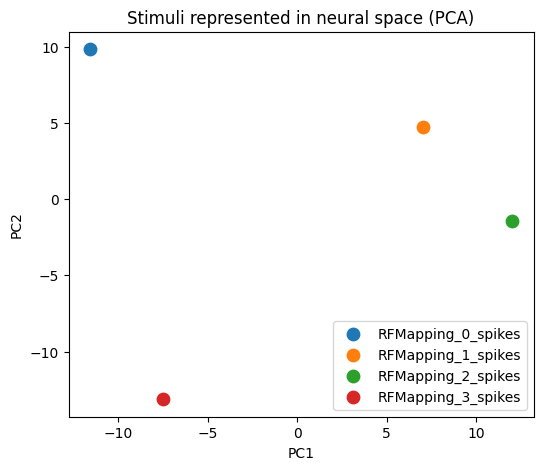

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


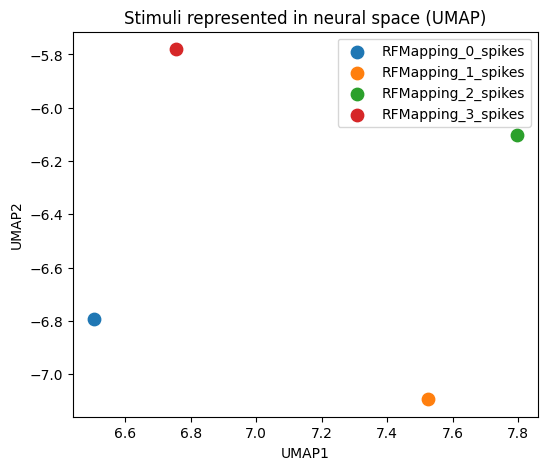

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap

# Ensure df is a DataFrame
df = pd.DataFrame(analysis_table)

# 1) Find stimulus columns (spike times per unit per stimulus)
stim_cols = [c for c in df.columns if c.startswith('RFMapping_') and c.endswith('_spikes')]
stim_cols = sorted(stim_cols)

if len(stim_cols) < 2:
    raise ValueError("Need at least 2 RFMapping_*_spikes columns to compare stimuli.")

# 2) Build neurons × stimuli matrix (counts per stimulus)
def _count_spikes(cell):
    if isinstance(cell, (list, np.ndarray)):
        return float(len(cell))
    try:
        return float(len(np.array(cell)))
    except Exception:
        return 0.0

X_counts = np.zeros((len(df), len(stim_cols)))
for j, col in enumerate(stim_cols):
    X_counts[:, j] = df[col].apply(_count_spikes).values

# X has shape (neurons × stimuli)
# Transpose → (stimuli × neurons), so each row = one stimulus
X = X_counts.T
print(f"Matrix shape (stimuli × neurons): {X.shape}")

# Optional: normalize per stimulus (z-score across neurons)
def zscore_rows(A):
    m = A.mean(axis=1, keepdims=True)
    s = A.std(axis=1, keepdims=True)
    s[s==0] = 1.0
    return (A - m) / s

Xz = zscore_rows(X)

# 3) PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(Xz)

plt.figure(figsize=(6,5))
for i, label in enumerate(stim_cols):
    plt.scatter(X_pca[i,0], X_pca[i,1], label=label, s=80)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("Stimuli represented in neural space (PCA)")
plt.legend()
plt.show()

# 4) UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(Xz)

plt.figure(figsize=(6,5))
for i, label in enumerate(stim_cols):
    plt.scatter(X_umap[i,0], X_umap[i,1], label=label, s=80)
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.title("Stimuli represented in neural space (UMAP)")
plt.legend()
plt.show()


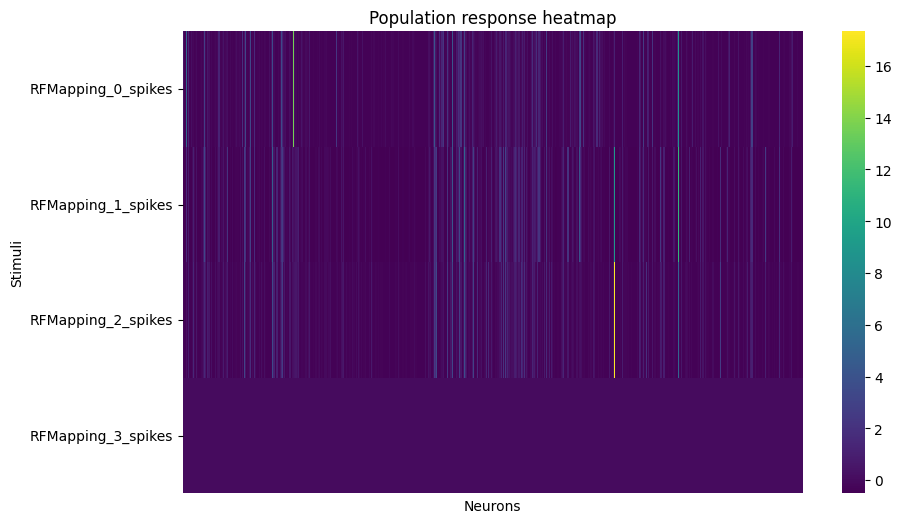

In [79]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(Xz, cmap="viridis", xticklabels=False, yticklabels=stim_cols)
plt.xlabel("Neurons")
plt.ylabel("Stimuli")
plt.title("Population response heatmap")
plt.show()


In [83]:
Xz

array([[ 0.32398508, -0.41645008, -0.41593705, ..., -0.41760441,
        -0.39285055, -0.37155968],
       [-0.4322647 , -0.50949526, -0.51026449, ..., -0.50287989,
        -0.26088057, -0.44534159],
       [-0.19293441, -0.41797503, -0.42261504, ..., -0.407767  ,
        -0.29118668, -0.35208685],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], shape=(4, 556))

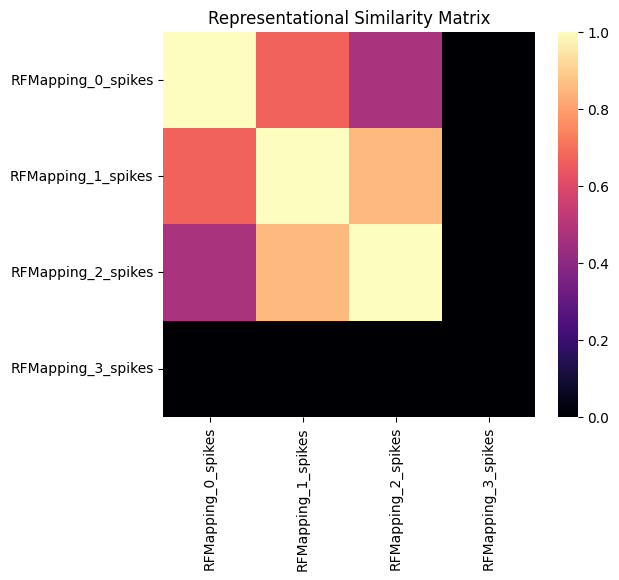

In [80]:
from sklearn.metrics.pairwise import cosine_similarity

sim = cosine_similarity(X)  # stimuli × stimuli
plt.figure(figsize=(6,5))
sns.heatmap(sim, xticklabels=stim_cols, yticklabels=stim_cols, cmap="magma", annot=False)
plt.title("Representational Similarity Matrix")
plt.show()


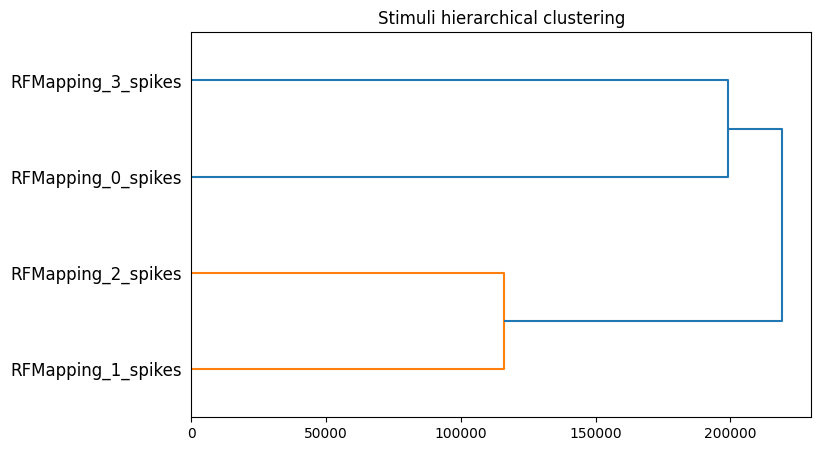

In [81]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(X, method='ward')
plt.figure(figsize=(8,5))
dendrogram(Z, labels=stim_cols, orientation="right")
plt.title("Stimuli hierarchical clustering")
plt.show()


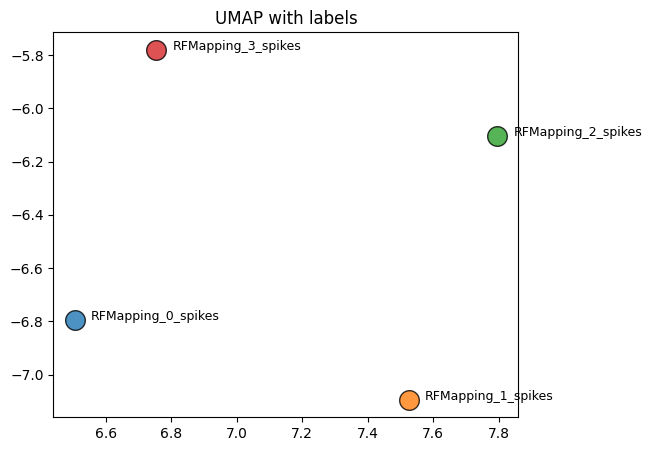

In [82]:
plt.figure(figsize=(6,5))
for i, label in enumerate(stim_cols):
    plt.scatter(X_umap[i,0], X_umap[i,1], s=200, edgecolor='k', label=label, alpha=0.8)
    plt.text(X_umap[i,0]+0.05, X_umap[i,1], label, fontsize=9)
plt.title("UMAP with labels")
plt.show()


In [93]:
units = nwbfile_zarr.units[:]
units.head()

spike_times  \
id                                                      
0   [860.7809320374699, 1325.947518695973, 1430.58...   
1   [17.43142939500891, 17.468196021101217, 17.526...   
2   [27.352251780071317, 36.339041862565615, 43.51...   
3   [41.37910296719798, 59.87144922636121, 73.4770...   
4   [17.38472944654533, 17.43199606105022, 17.4949...   

                                           electrodes  \
id                                                      
0   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
3   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
4   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                        waveform_mean  \
id                                                      
0   [[-0.4310527741909027, 0.0, 0.1539475172758102...   
1   [[-0.636479914188385, 0.0, -1.2869997024536133...   
2   [[-1.995410680770874, 0.0, -1.410410761833191,...   
3   [[-2.2606775760650635, 0.0, -1.893812775611877...   
4   [[-0.8938802480697632, 0.0, -0.425880044698715...   

                                          waveform_sd  \
id                                                      
0   [[21.599468231201172, 0.0, 19.95810890197754, ...   
1   [[15.821245193481445, 0.0, 14.6087064743042, 0...   
2   [[26.957242965698242, 0.0, 24.961811065673828,...   
3   [[33.657691955566406, 0.0, 32.03106689453125, ...   
4   [[16.392057418823242, 0.0, 15.471063613891602,...   

                               unit_name  half_width  nn_hit_rate device_name  \
id                                                                              
0   482f6f21-16d0-4cee-93ed-fd051303051a    0.000257     0.549020      ProbeA   
1   84ac590e-47f9-4c52-aaaa-da99c53606ae    0.000223     0.568389      ProbeA   
2   daf591fc-684f-403a-ab62-3656462428ee    0.000217     0.392670      ProbeA   
3   3c33bff2-f3f8-495e-97ff-635fdf97791c    0.000240     0.181818      ProbeA   
4   8598dc2d-3be4-4704-a1c7-48e2b6a985bc    0.000150     0.626911      ProbeA   

    estimated_x  spread  ...  decoder_probability  ks_unit_id  decoder_label  \
id                       ...                                                   
0         15.97   192.0  ...                 0.94         0.0            mua   
1        -16.05   192.0  ...                 0.59         1.0            mua   
2        -61.38   192.0  ...                 0.85         2.0            mua   
3          6.14   192.0  ...                 0.90         3.0            mua   
4        -20.09   150.0  ...                 0.88         4.0            sua   

    presence_ratio  amplitude_cv_range  drift_std  silhouette  \
id                                                              
0         0.389706                 NaN        NaN    0.260075   
1         1.000000                 NaN        NaN    0.092592   
2         0.720588                 NaN        NaN    0.057229   
3         0.720588                 NaN        NaN    0.012152   
4         1.000000                 NaN  12.551991    0.114247   

    amplitude_median  sync_spike_2  amplitude_cutoff  
id                                                    
0         182.519990      0.052632               NaN  
1          39.780000      0.024288          0.000080  
2          49.140000      0.023973               NaN  
3          80.729996      0.118644               NaN  
4          74.880000      0.021516          0.000043  

[5 rows x 52 columns]

In [108]:
np.unique(units.default_qc,return_counts=True)

(array(['False', 'True'], dtype=object), array([447, 272]))

In [109]:
np.sum(units.presence_ratio > 0.9)

np.int64(373)

In [ ]:
#50-100ms large_footprints

In [110]:
units.columns

Index(['spike_times', 'electrodes', 'waveform_mean', 'waveform_sd',
       'unit_name', 'half_width', 'nn_hit_rate', 'device_name', 'estimated_x',
       'spread', 'isi_violations_count', 'l_ratio', 'isolation_distance',
       'exp_decay', 'num_positive_peaks', 'num_negative_peaks',
       'velocity_above', 'estimated_z', 'peak_trough_ratio', 'sync_spike_4',
       'recovery_slope', 'num_spikes', 'firing_range', 'default_qc',
       'amplitude_cv_median', 'amplitude', 'd_prime', 'repolarization_slope',
       'peak_to_valley', 'sliding_rp_violation', 'isi_violations_ratio',
       'sync_spike_8', 'drift_ptp', 'firing_rate', 'velocity_below', 'snr',
       'rp_contamination', 'rp_violations', 'depth', 'drift_mad',
       'estimated_y', 'nn_miss_rate', 'decoder_probability', 'ks_unit_id',
       'decoder_label', 'presence_ratio', 'amplitude_cv_range', 'drift_std',
       'silhouette', 'amplitude_median', 'sync_spike_2', 'amplitude_cutoff'],
      dtype='object')

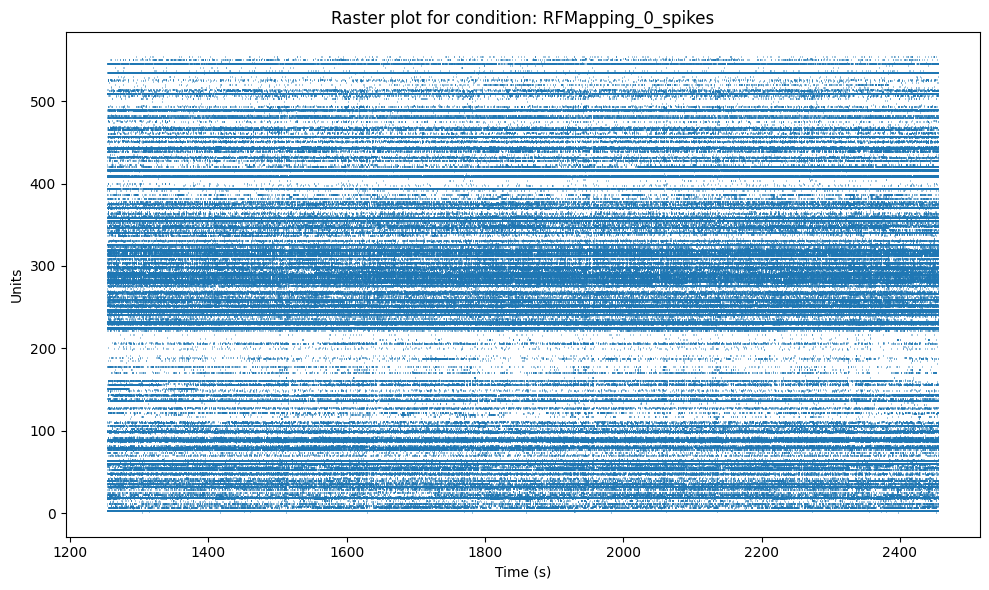

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrame if not already
df = pd.DataFrame(analysis_table)

# Pick your condition column
SPIKE_COL = "RFMapping_0_spikes"   # <- change to the condition you want

# Extract spike times per unit
def to_list(x):
    if isinstance(x, list):
        return x
    try:
        return list(np.array(x).ravel())
    except Exception:
        return []

spike_lists = [to_list(x) for x in df[SPIKE_COL].values]

# Plot raster
plt.figure(figsize=(10,6))
plt.eventplot(spike_lists, linelengths=0.8, linewidths=0.6)
plt.xlabel("Time (s)")   # adjust if spike times are samples
plt.ylabel("Units")
plt.title(f"Raster plot for condition: {SPIKE_COL}")
plt.tight_layout()
plt.show()

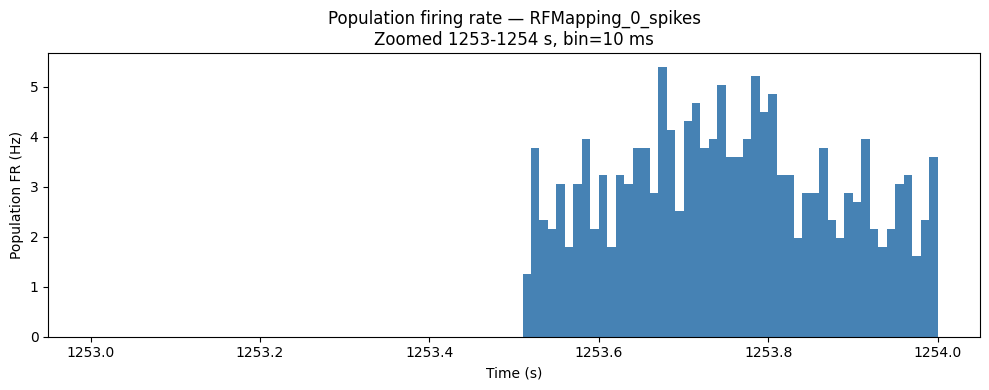

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(analysis_table)
SPIKE_COL = "RFMapping_0_spikes"

# --- CONFIG ---
BIN_SIZE = 0.01             # 10 ms bins
TIME_WINDOW = (1253, 1254)  # <-- zoomed 1 second window

# --- Extract spikes across all neurons ---
all_spikes = []
for s in df[SPIKE_COL].values:
    if isinstance(s, list):
        all_spikes.extend(s)
    else:
        try:
            arr = np.array(s).ravel()
            all_spikes.extend(arr.tolist())
        except Exception:
            pass

all_spikes = np.array(all_spikes)
if all_spikes.size == 0:
    raise ValueError(f"No spikes found in {SPIKE_COL}")

# Restrict to time window
tmin, tmax = TIME_WINDOW
all_spikes = all_spikes[(all_spikes >= tmin) & (all_spikes <= tmax)]

# Bin
bins = np.arange(tmin, tmax + BIN_SIZE, BIN_SIZE)
counts, edges = np.histogram(all_spikes, bins=bins)

# Normalize to population firing rate (Hz)
n_neurons = len(df)
fr = counts / (BIN_SIZE * n_neurons)

# --- Plot ---
plt.figure(figsize=(10,4))
plt.bar(edges[:-1], fr, width=BIN_SIZE, align="edge", color="steelblue")
plt.xlabel("Time (s)")
plt.ylabel("Population FR (Hz)")
plt.title(f"Population firing rate — {SPIKE_COL}\nZoomed {tmin}-{tmax} s, bin={BIN_SIZE*1000:.0f} ms")
plt.tight_layout()
plt.show()


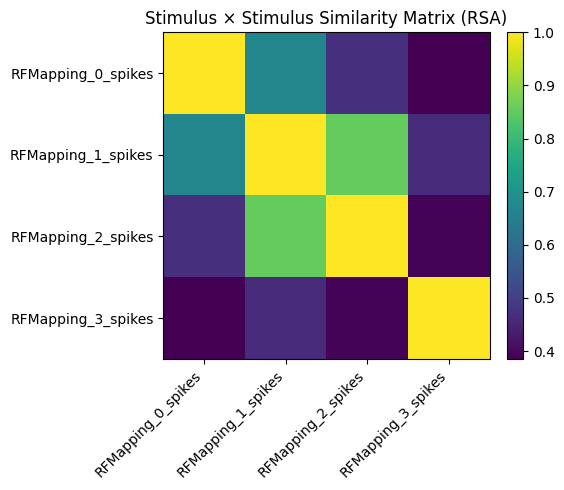

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Convert to DataFrame if not already
df = pd.DataFrame(analysis_table)

# --- Step 1: pick stimulus columns (spikes per neuron per stimulus)
stim_cols = [c for c in df.columns if c.startswith("RFMapping_") and c.endswith("_spikes")]
stim_cols = sorted(stim_cols)

if len(stim_cols) < 2:
    raise ValueError("Need at least 2 RFMapping_*_spikes columns for RSA.")

# --- Step 2: build stimulus × neuron matrix
def count_spikes(cell):
    if isinstance(cell, list):
        return len(cell)
    try:
        return len(np.array(cell).ravel())
    except Exception:
        return 0

# Each row = stimulus, each col = neuron
X = np.zeros((len(stim_cols), len(df)))
for i, col in enumerate(stim_cols):
    X[i, :] = df[col].apply(count_spikes).values

# --- Step 3: compute similarity between stimuli (cosine similarity)
S = cosine_similarity(X)   # shape = (stimuli × stimuli)

# --- Step 4: plot the similarity matrix
plt.figure(figsize=(6,5))
im = plt.imshow(S, cmap="viridis", interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(stim_cols)), stim_cols, rotation=45, ha="right")
plt.yticks(range(len(stim_cols)), stim_cols)
plt.title("Stimulus × Stimulus Similarity Matrix (RSA)")
plt.tight_layout()
plt.show()
